In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# Exploring data

In [9]:
negative_spike_count = np.sum(np.any(dat['sresp'] < 0, axis=1))
print(negative_spike_count)


2


In [10]:
i_neurons = [0, 321]
i_print = slice(0,10)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    dat['sresp'][i].dtype,
    dat['sresp'][i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 2.9820833  8.409119  12.720393   0.         0.         7.274833
 18.580465   3.79022    3.4137561  3.1182032]


Neuron 321:
float32
[ 9.140973  0.        1.862105  0.       16.781614 16.269245 15.841542
  0.       40.110836  0.      ]




sresp basically has 11983 neurons, and 7018 timebins for each neuron. So in each timebin, we see the neuron spike response. Each timebin is consecutive for 1.2s so the spike response is sequential

In [7]:
print("Max:",np.max(dat['sresp']),"\nMin:",np.min(dat['sresp']),"\nMean: ",np.mean(dat['sresp']),"\nMedian: ",np.median(dat['sresp']))

Max: 2417.7021 
Min: -5.6768604e-06 
Mean:  39.823532 
Median:  15.809069


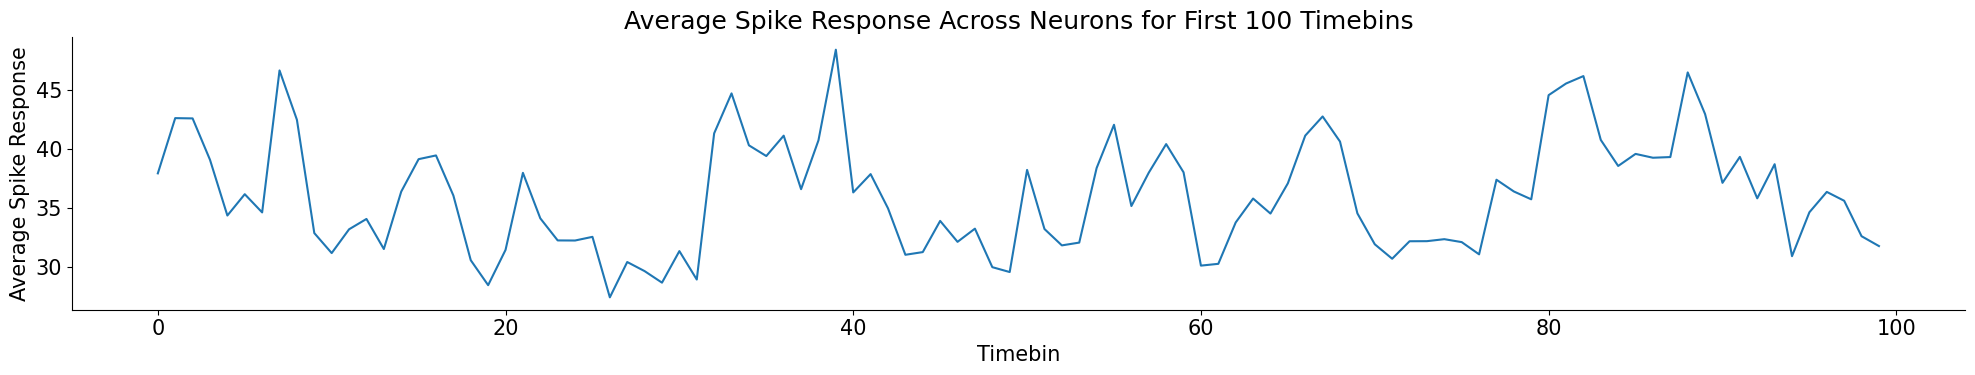

In [8]:
# Average spike response across all neurons for the first few timebins
avg_spike_response = np.mean(dat['sresp'][:, :100], axis=0)

plt.plot(avg_spike_response)
plt.xlabel('Timebin')
plt.ylabel('Average Spike Response')
plt.title('Average Spike Response Across Neurons for First 100 Timebins')
plt.show()


6.8859396 4.776567


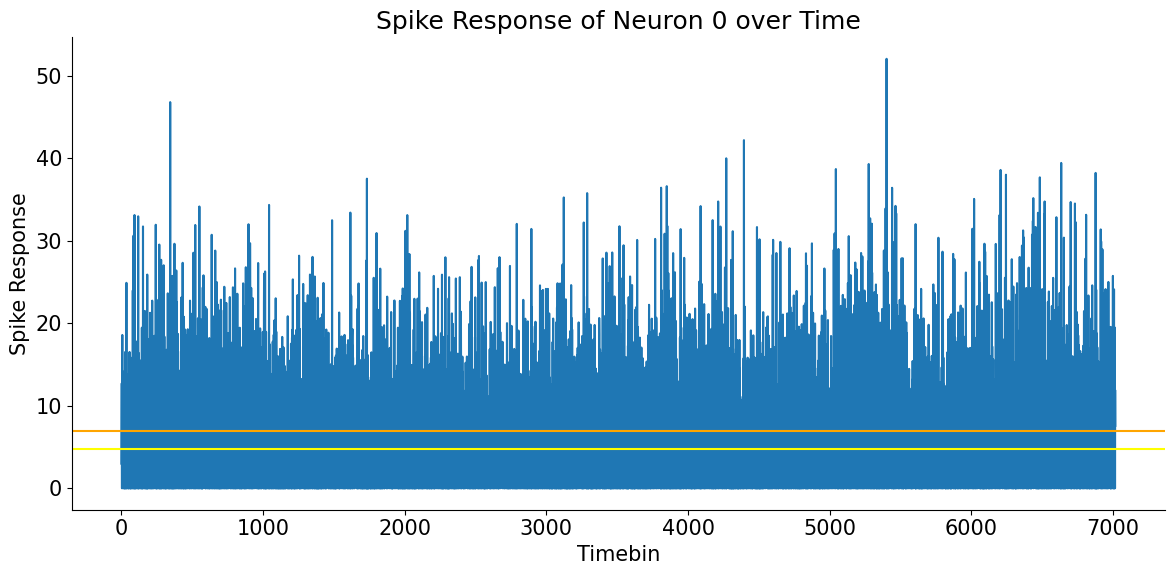

In [9]:
timebins = np.arange(7018)
mean_spike_resp = np.mean(dat['sresp'][0])
median_spike_resp = np.median(dat['sresp'][0])
print(mean_spike_resp, median_spike_resp)
plt.figure(figsize=(12, 6))
plt.plot(timebins, dat['sresp'][0])
plt.axhline(mean_spike_resp, color="orange", label="Mean neuron")
plt.axhline(median_spike_resp, color="yellow", label="Median neuron")
plt.xlabel('Timebin')
plt.ylabel('Spike Response')
plt.title('Spike Response of Neuron 0 over Time')
plt.show()

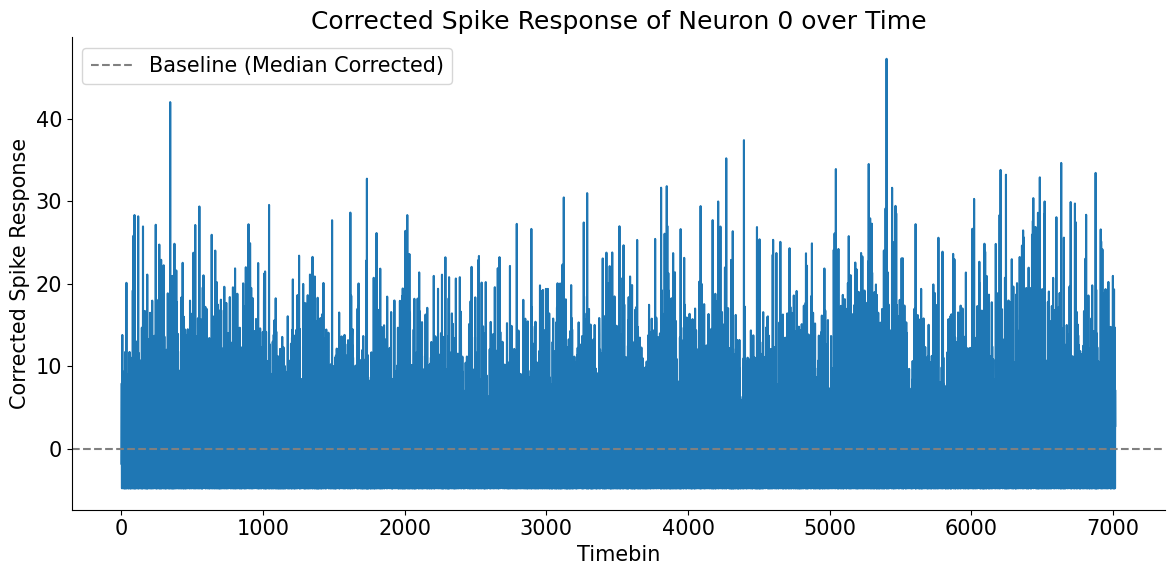

In [10]:
# Baseline correction by subtracting the median
baseline_corrected_resp = dat['sresp'][0] - median_spike_resp

# Plot the corrected spike response
plt.figure(figsize=(12, 6))
plt.plot(timebins, baseline_corrected_resp)
plt.axhline(0, color="gray", linestyle="--", label="Baseline (Median Corrected)")
plt.xlabel('Timebin')
plt.ylabel('Corrected Spike Response')
plt.title('Corrected Spike Response of Neuron 0 over Time')
plt.legend()
plt.show()


15.088903427124023


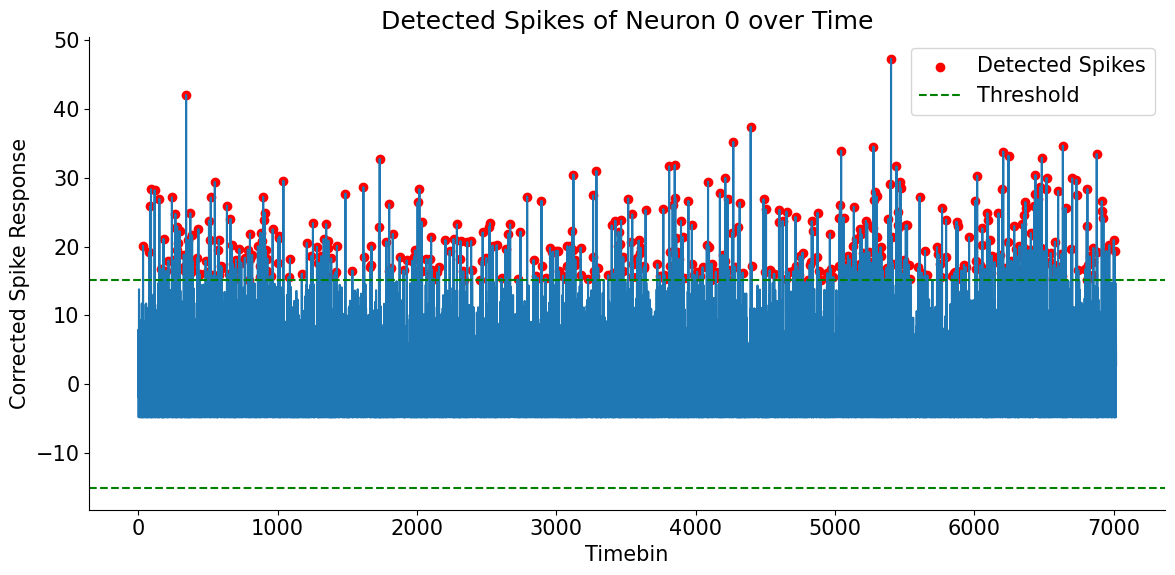

In [11]:
# Calculate standard deviation of the baseline-corrected data
std_spike_resp = np.std(baseline_corrected_resp)

# Define the new threshold (e.g., 2 times the standard deviation)
new_threshold = 2 * std_spike_resp
print(new_threshold)

# Detect spikes
spike_times = np.where(baseline_corrected_resp > new_threshold)[0]

# Plot detected spikes
plt.figure(figsize=(12, 6))
plt.plot(timebins, baseline_corrected_resp)
plt.scatter(spike_times, baseline_corrected_resp[spike_times], color='red', label='Detected Spikes')
plt.axhline(new_threshold, color="green", linestyle="--", label="Threshold")
plt.axhline(-new_threshold, color="green", linestyle="--")
plt.xlabel('Timebin')
plt.ylabel('Corrected Spike Response')
plt.title('Detected Spikes of Neuron 0 over Time')
plt.legend()
plt.show()


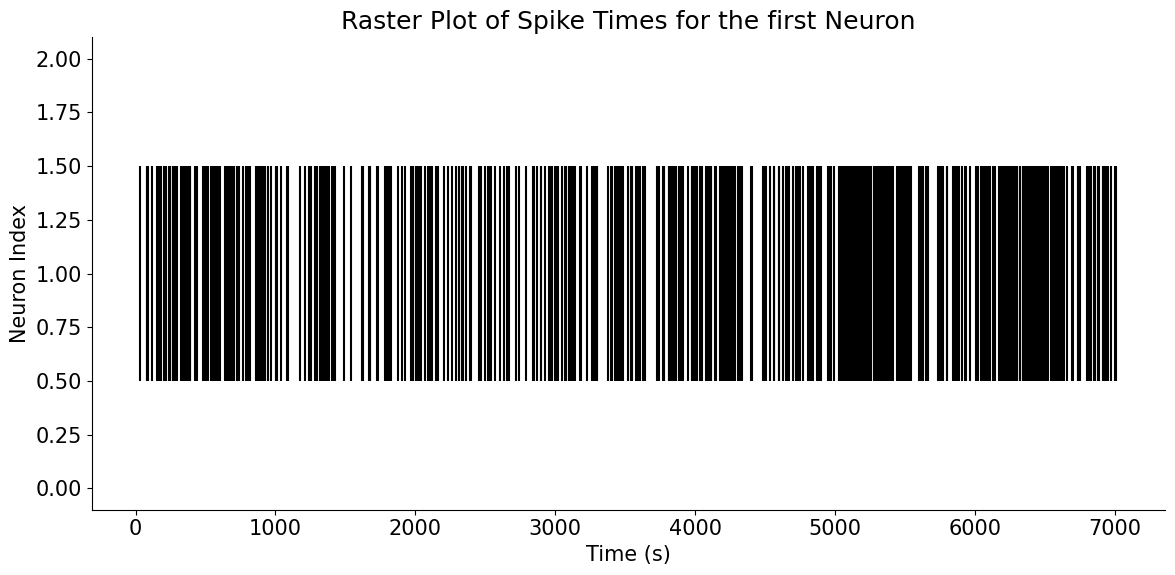

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spike_times, color='black')
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for the first Neuron")
plt.show()


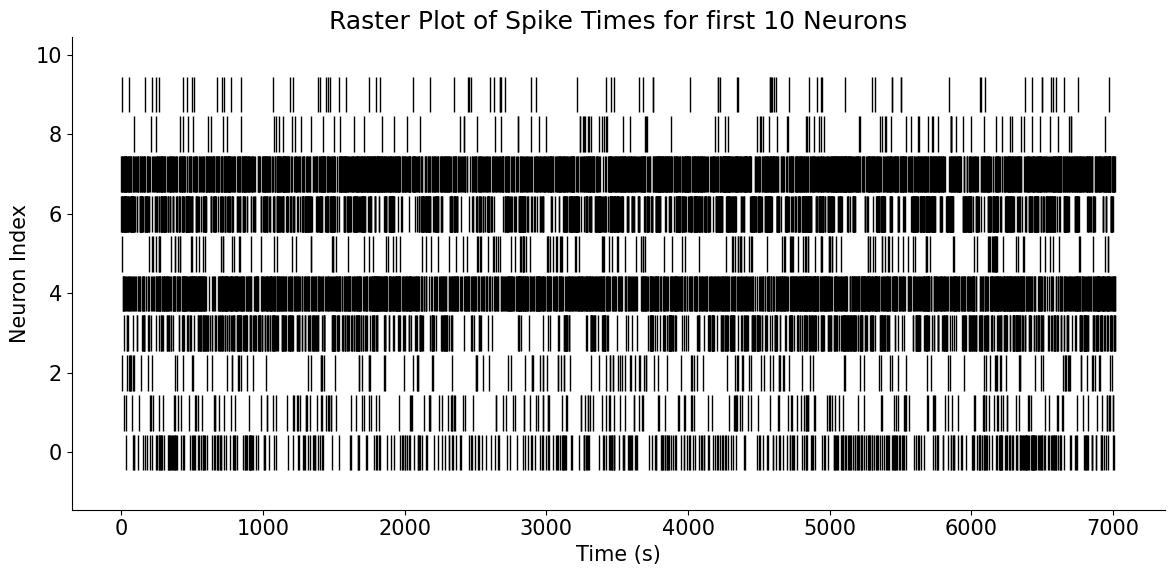

In [13]:
import numpy as np
import matplotlib.pyplot as plt
spikes=[]
for i in range(10):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    spikes.append(spike_times)
offsets = np.arange(10)


# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spikes, color='black', linewidth=1, lineoffsets=offsets, linelengths=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for first 10 Neurons")
plt.show()


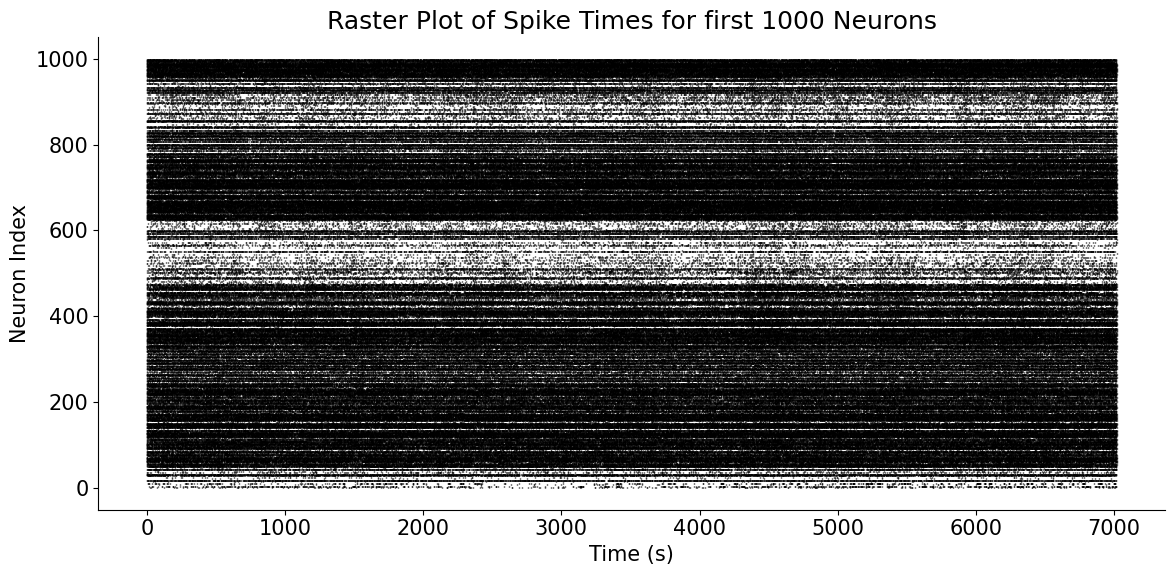

In [19]:
import numpy as np
import matplotlib.pyplot as plt
spikes=[]
for i in range(1000):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    spikes.append(spike_times)
offsets = np.arange(1000)


# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spikes, color='black', linewidth=1, lineoffsets=offsets, linelengths=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for first 1000 Neurons")
plt.show()


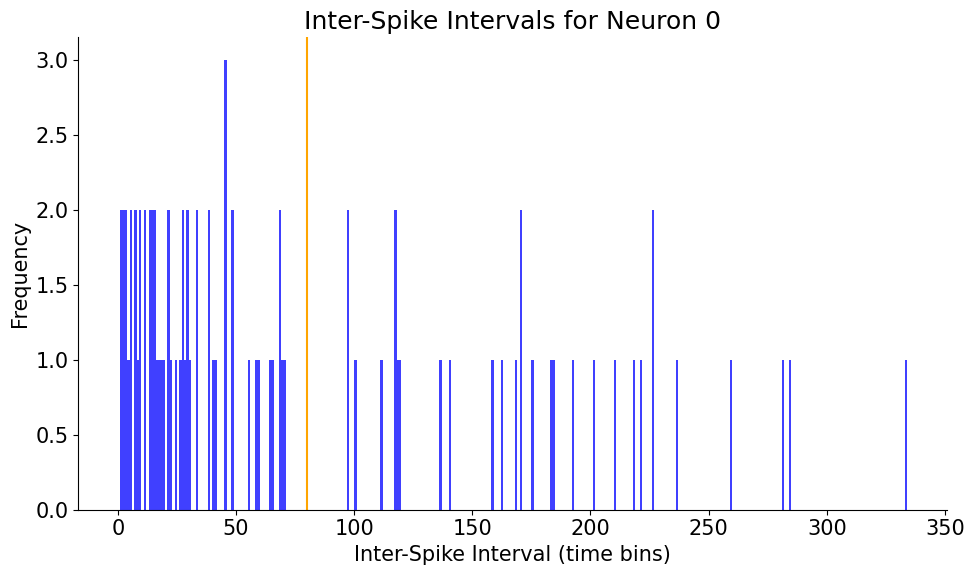

In [14]:
# Calculate inter-spike intervals (ISIs)
isis = np.diff(spike_times)

# Plot ISIs
plt.figure(figsize=(10, 6))
plt.hist(isis, bins=np.arange(0, np.max(isis) + 1, 1), alpha=0.75, color='blue')
plt.axvline(isis.mean(), color="orange", label="Mean ISI")
plt.xlabel('Inter-Spike Interval (time bins)')
plt.ylabel('Frequency')
plt.title('Inter-Spike Intervals for Neuron 0')
plt.show()

C:\Users\adith\AppData\Local\Temp\ipykernel_13648\2919665611.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


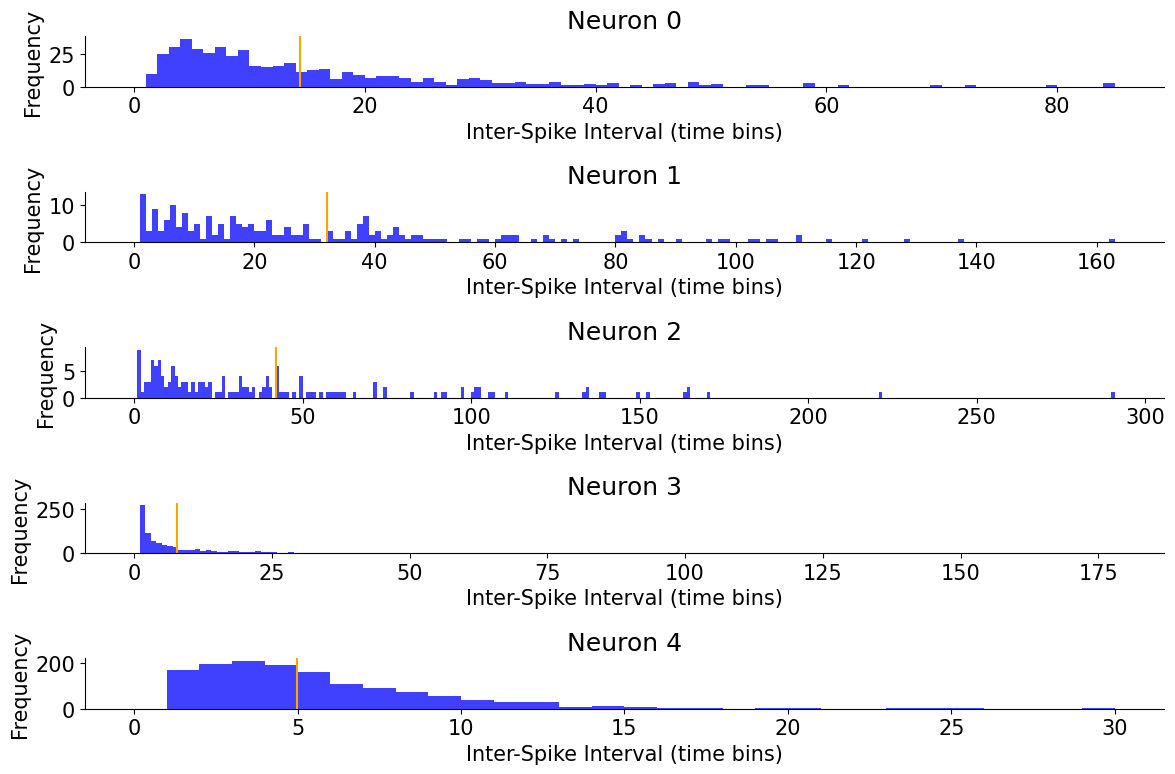

In [15]:
num_neurons = 5  # Number of neurons to analyze
plt.figure(figsize=(12, 8))

for i in range(num_neurons):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    isis = np.diff(spike_times)

    plt.subplot(num_neurons, 1, i + 1)
    plt.hist(isis, bins=np.arange(0, np.max(isis) + 1, 1), alpha=0.75, color='blue')
    plt.xlabel('Inter-Spike Interval (time bins)')
    plt.axvline(isis.mean(), color="orange", label="Mean ISI")
    plt.ylabel('Frequency')
    plt.title(f'Neuron {neuron_idx}')
    plt.tight_layout()

plt.show()


In [16]:
import numpy as np

# Compute average firing rate across all neurons for each time bin
avg_firing_rate = np.mean(dat['sresp'], axis=0)

# Define thresholds for high and low firing activity
high_firing_threshold = np.percentile(avg_firing_rate, 75)  # Top 25% as high firing
low_firing_threshold = np.percentile(avg_firing_rate, 25)   # Bottom 25% as low firing

# Identify time bins with high and low firing activity
high_firing_bins = avg_firing_rate >= high_firing_threshold
low_firing_bins = avg_firing_rate <= low_firing_threshold

# Extract pupil area and running speed
pupil_area = dat['pupilArea']
running_speed = dat['run']

# Extract data for high and low firing periods
high_firing_pupil_area = pupil_area[high_firing_bins]
low_firing_pupil_area = pupil_area[low_firing_bins]
high_firing_running_speed = running_speed[high_firing_bins]
low_firing_running_speed = running_speed[low_firing_bins]


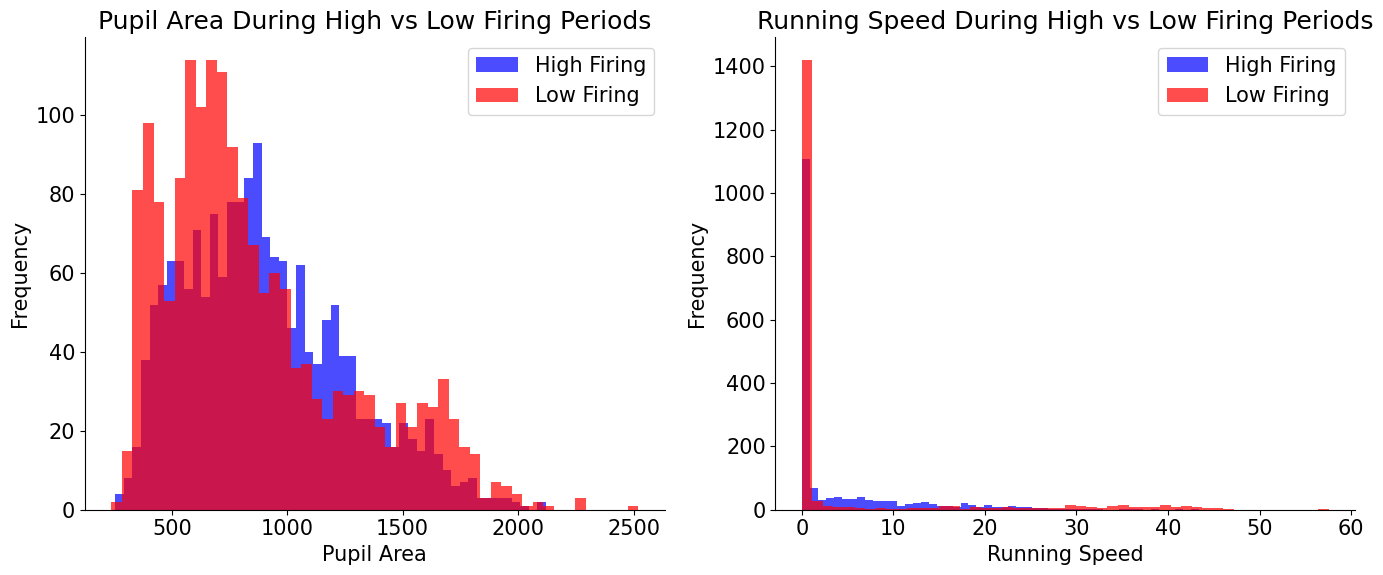

In [17]:
import matplotlib.pyplot as plt

# Plot Pupil Area
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(high_firing_pupil_area, bins=50, alpha=0.7, color='blue', label='High Firing')
plt.hist(low_firing_pupil_area, bins=50, alpha=0.7, color='red', label='Low Firing')
plt.xlabel('Pupil Area')
plt.ylabel('Frequency')
plt.title('Pupil Area During High vs Low Firing Periods')
plt.legend()

# Plot Running Speed
plt.subplot(1, 2, 2)
plt.hist(high_firing_running_speed, bins=50, alpha=0.7, color='blue', label='High Firing')
plt.hist(low_firing_running_speed, bins=50, alpha=0.7, color='red', label='Low Firing')
plt.xlabel('Running Speed')
plt.ylabel('Frequency')
plt.title('Running Speed During High vs Low Firing Periods')
plt.legend()

plt.tight_layout()
plt.show()


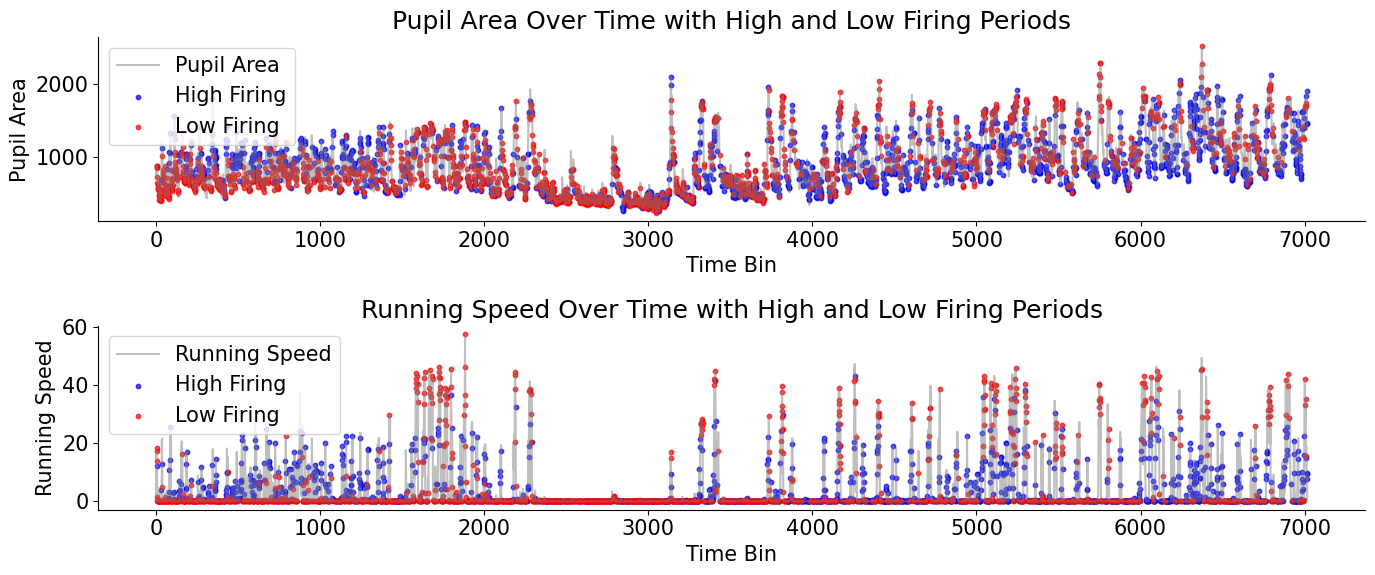

In [18]:
# Plot Time Series Data
plt.figure(figsize=(14, 6))

# Pupil Area
plt.subplot(2, 1, 1)
plt.plot(dat['pupilArea'], label='Pupil Area', color='gray', alpha=0.5)
plt.scatter(np.where(high_firing_bins)[0], dat['pupilArea'][high_firing_bins], color='blue', label='High Firing', alpha=0.7, s=10)
plt.scatter(np.where(low_firing_bins)[0], dat['pupilArea'][low_firing_bins], color='red', label='Low Firing', alpha=0.7, s=10)
plt.xlabel('Time Bin')
plt.ylabel('Pupil Area')
plt.title('Pupil Area Over Time with High and Low Firing Periods')
plt.legend()

# Running Speed
plt.subplot(2, 1, 2)
plt.plot(dat['run'], label='Running Speed', color='gray', alpha=0.5)
plt.scatter(np.where(high_firing_bins)[0], dat['run'][high_firing_bins], color='blue', label='High Firing', alpha=0.7, s=10)
plt.scatter(np.where(low_firing_bins)[0], dat['run'][low_firing_bins], color='red', label='Low Firing', alpha=0.7, s=10)
plt.xlabel('Time Bin')
plt.ylabel('Running Speed')
plt.title('Running Speed Over Time with High and Low Firing Periods')
plt.legend()

plt.tight_layout()
plt.show()


# PCA

In [28]:
import numpy as np
import pandas as pd

sresp = dat['sresp']  # Neural response data: (11983 neurons x 7018 timebins)
pupilArea = dat['pupilArea']  # Pupil area data: (7018,)
run = dat['run']  # Running speed data: (7018,)
# Mean-center the neural response data
sresp_mean_centered = sresp - np.mean(sresp, axis=1, keepdims=True)


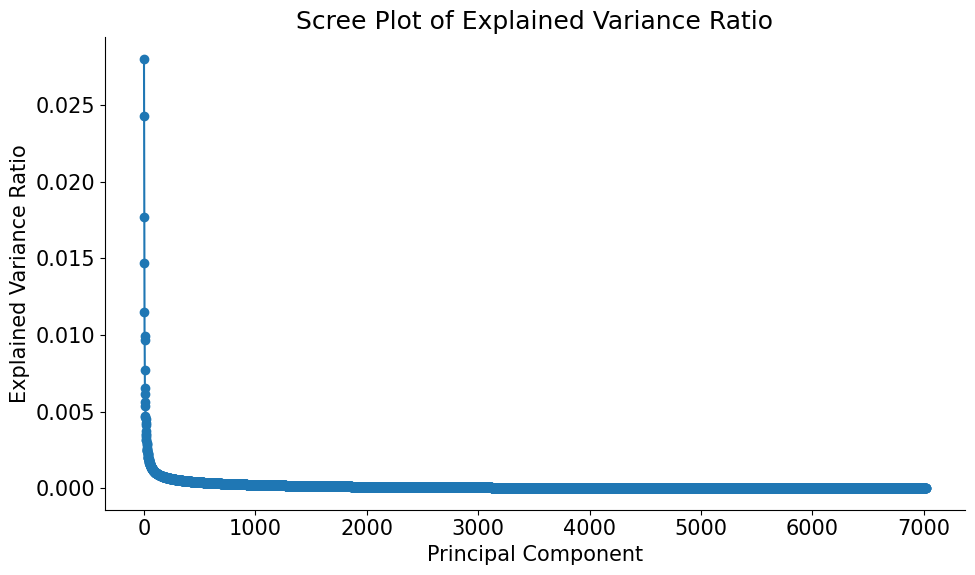

In [29]:
pca = PCA()
principal_components = pca.fit_transform(sresp_mean_centered.T)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot of Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


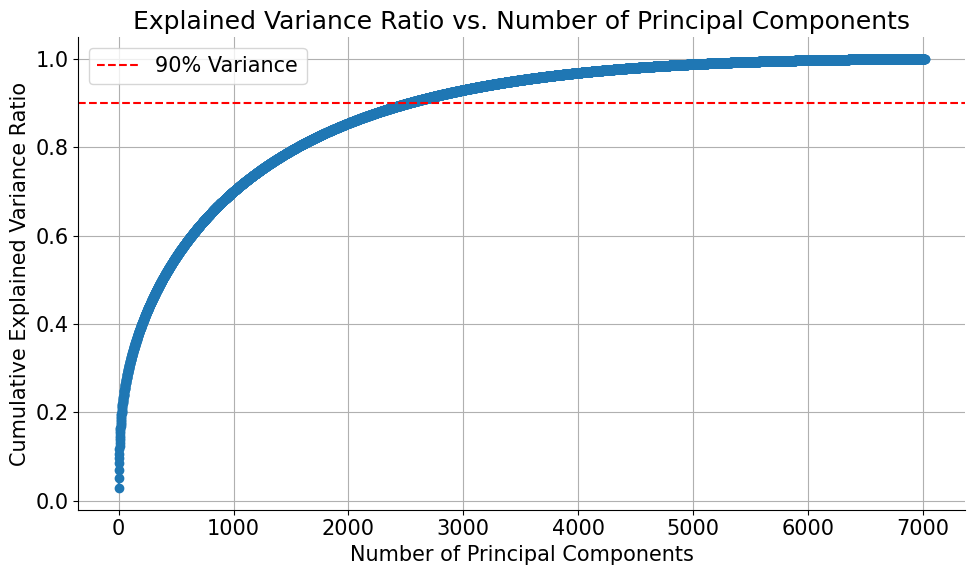

In [30]:
import matplotlib.pyplot as plt

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.axhline(0.90, color='red', linestyle='--', label='90% Variance')
plt.legend()
plt.grid()
plt.show()


In [32]:
# Find number of components to explain at least 90% variance
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance_ratio)
num_components_for_90_variance = np.argmax(explained_variance_cumulative >= 0.90) + 1
print(f'Number of principal components to explain at least 90% variance: {num_components_for_90_variance}')


Number of principal components to explain at least 90% variance: 2526


In [33]:
num_pcs = 2526
pca = PCA(n_components=num_pcs)
reduced_data = pca.fit_transform(sresp_mean_centered.T)  # (7018 timebins x 2526 PCs)

# Flatten the 2D arrays to 1D
pupilArea_flattened = pupilArea.flatten()  # Shape (7018,)
run_flattened = run.flatten()  # Shape (7018,)
num_pcs_to_use = 3
principal_components_to_use = reduced_data[:, :num_pcs_to_use]


# Check the shapes to ensure they are 1D
print(f'pupilArea_flattened.shape: {pupilArea_flattened.shape}')
print(f'run_flattened.shape: {run_flattened.shape}')


pupilArea_flattened.shape: (7018,)
run_flattened.shape: (7018,)


In [34]:
# Create a DataFrame for visualization and analysis
data_for_regression = pd.DataFrame({
    'Pupil Area': pupilArea_flattened,
    'Running Speed': run_flattened,
    'Principal Component 1': principal_components_to_use[:, 0],
    'Principal Component 2': principal_components_to_use[:, 1],
    'Principal Component 3': principal_components_to_use[:, 2],  # Add more PCs if needed
})

# Check the DataFrame
print(data_for_regression.head())


   Pupil Area  Running Speed  Principal Component 1  Principal Component 2  \
0  833.333895       0.043625            -814.789551             770.032166   
1  745.139269       5.688507             843.124756            1967.033081   
2  838.572260       9.130915             694.729309            1296.547607   
3  836.409290      16.939346             532.657166            1084.760620   
4  843.813529      17.465670            1101.997070            -103.417915   

   Principal Component 3  
0             163.206497  
1             200.508163  
2             398.176666  
3             784.997375  
4              93.789055  


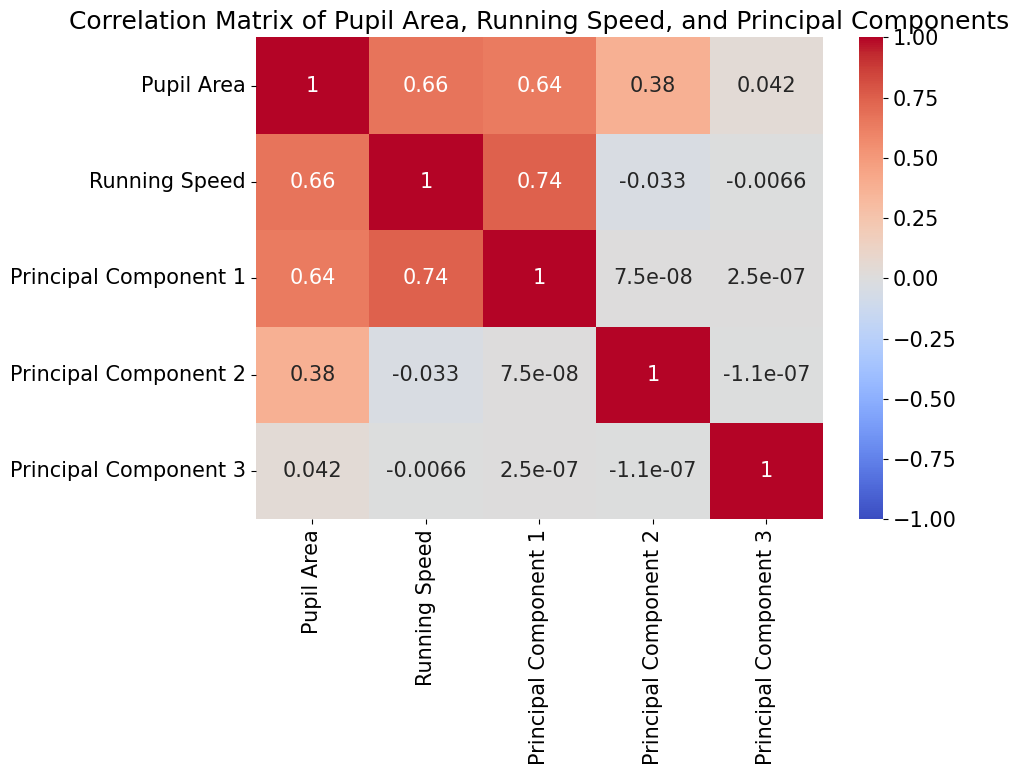

In [35]:
# Correlation Matrix
correlation_matrix = data_for_regression.corr()

# Plot Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Pupil Area, Running Speed, and Principal Components')
plt.show()


# Predictions

## Just Raw Data without any PCA

In [31]:
# Data Preparation
X = dat['sresp'].T  # Transpose to get shape (timebins, neurons)
y = dat['pupilArea'].flatten()

# Split the data 
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)

## Ridge

In [6]:
# Define alpha range for RidgeCV
alphas = np.logspace(-6, 6, 13)

# Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_cv.predict(X_test)
y_ridge=y_pred

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Ridge Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {ridge_cv.alpha_}')

Ridge Regression without PCA:
Mean Squared Error: 27127.85
R^2 Score: 0.80
Best Alpha: 1000000.0


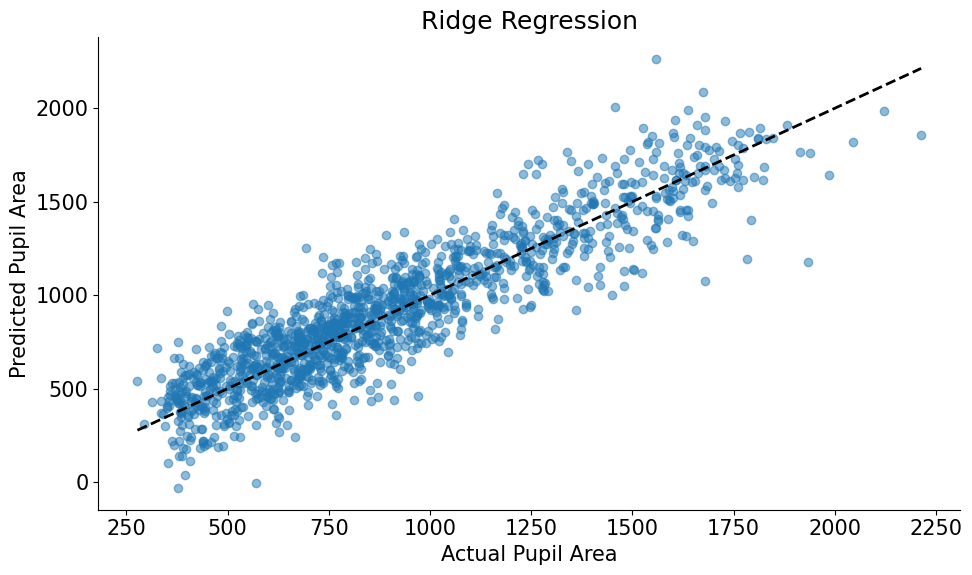

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression')
plt.show()

## Lasso

In [8]:
from sklearn.linear_model import LassoCV

# Lasso Regression with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_cv.predict(X_test)
y_lasso = y_pred

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Lasso Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {lasso_cv.alpha_}')


Lasso Regression without PCA:
Mean Squared Error: 15332.55
R^2 Score: 0.89
Best Alpha: 100.0


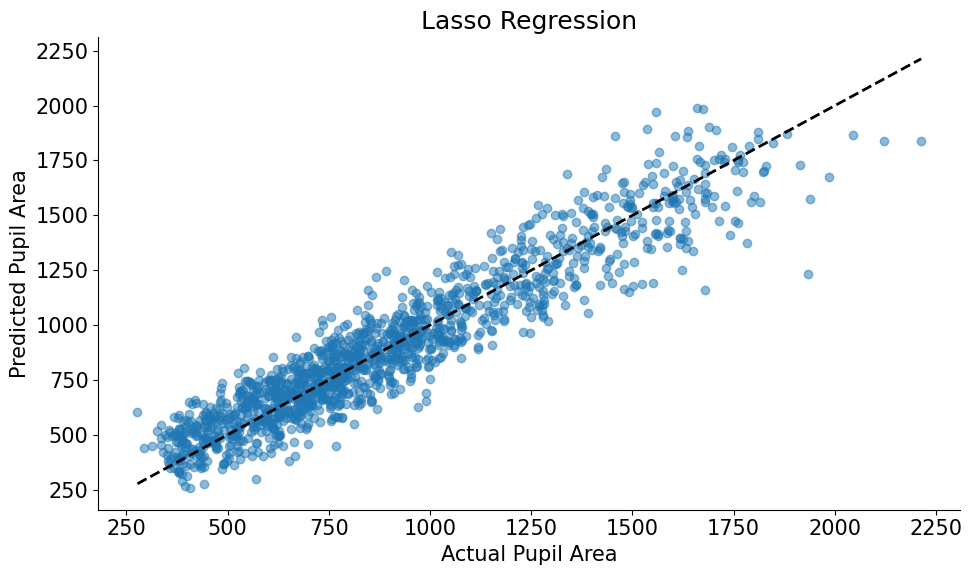

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression')
plt.show()

## ElasticNet

In [10]:
from sklearn.linear_model import ElasticNetCV

# ElasticNet with cross-validation
elasticnet_cv = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5)
elasticnet_cv.fit(X_train, y_train)

# Predict on test set
y_pred = elasticnet_cv.predict(X_test)
y_elastic = y_pred
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'ElasticNet without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {elasticnet_cv.alpha_}, Best L1 ratio: {elasticnet_cv.l1_ratio_}')


ElasticNet without PCA:
Mean Squared Error: 14961.37
R^2 Score: 0.89
Best Alpha: 1000.0, Best L1 ratio: 0.1


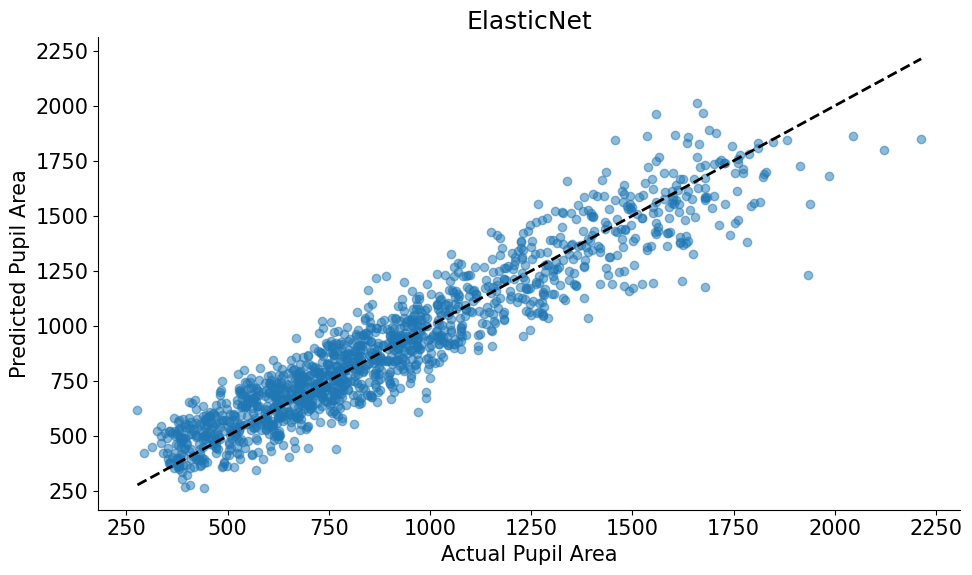

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet')
plt.show()

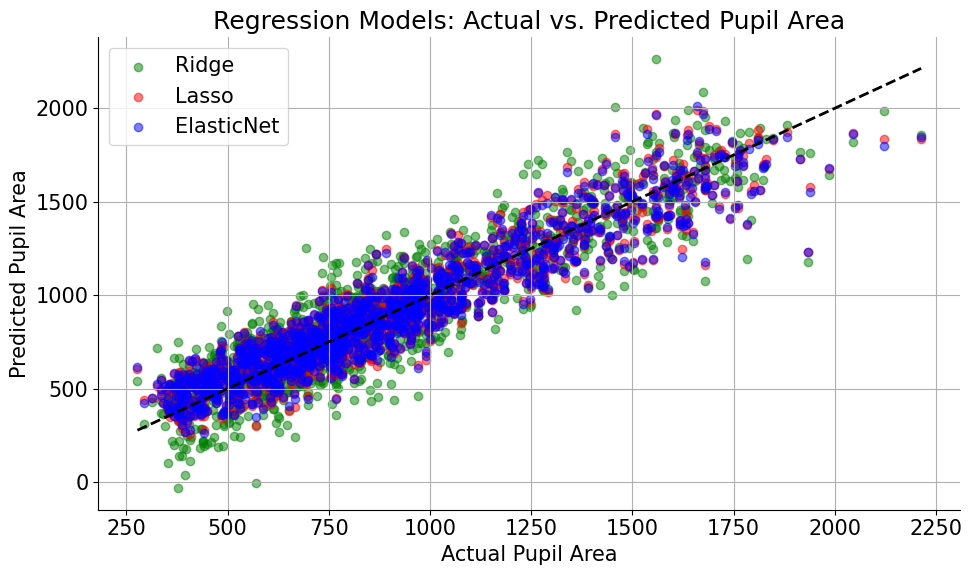

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_ridge, color='green', alpha=0.5, label='Ridge')
plt.scatter(y_test, y_lasso, color='red', alpha=0.5, label='Lasso')
plt.scatter(y_test, y_elastic, color='blue', alpha=0.5, label='ElasticNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Regression Models: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

Ridge Regression: Ridge regression adds a penalty equal to the sum of the squared values of the coefficients. This penalty shrinks the coefficients towards zero, but it doesn't set any of them exactly to zero.

Lasso Regression: Lasso regression adds a penalty equal to the sum of the absolute values of the coefficients. This penalty can shrink some coefficients to exactly zero, thus performing feature selection.

ElasticNet Regression: ElasticNet combines both the L1 and L2 penalties of the Lasso and Ridge methods. The parameter r determines the balance between the Lasso and Ridge penalty terms. When r=0, ElasticNet is equivalent to Ridge Regression, and when r=1, it is equivalent to Lasso Regression. We try to find an r that fits our data [some mix between ridge and lasso]

#### Insights:
Lasso and Elastic Net have the same accuracy and Ridge has a little lower accuracy. But elastic net is a little better than lasso since the mse is a bit lower

# Temporal Analysis

In [13]:
from scipy.signal import correlate

neural_responses = dat['sresp']  # Shape: (neurons, timebins)
pupil_area = dat['pupilArea'].flatten()    # Shape: (timebins,)

# Initialize a list to store cross-correlations for each neuron
all_correlations = []
all_lags = None

# Compute cross-correlation for each neuron
for neuron_idx in range(neural_responses.shape[0]):
    neural_response = neural_responses[neuron_idx, :]
    correlation = correlate(neural_response, pupil_area)
    lags = np.arange(-len(pupil_area) + 1, len(neural_response))
    
    if all_lags is None:
        all_lags = lags
    
    all_correlations.append(correlation)

# Convert to numpy array for easier manipulation
all_correlations = np.array(all_correlations)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


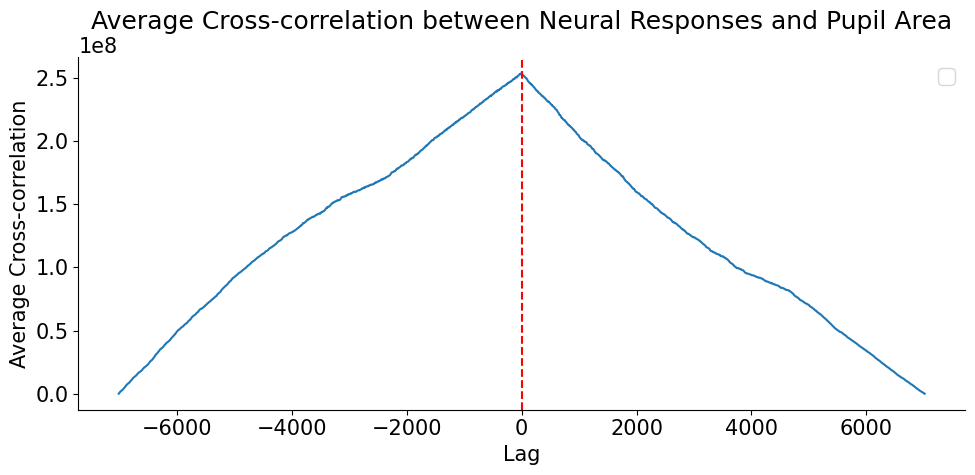

In [14]:
# Compute average cross-correlation across all neurons
average_correlation = np.mean(all_correlations, axis=0)

# Plot the average cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(all_lags, average_correlation)
plt.xlabel('Lag')
plt.ylabel('Average Cross-correlation')
plt.title('Average Cross-correlation between Neural Responses and Pupil Area')
plt.axvline(x=0, color='r', linestyle='--')
plt.legend()
plt.show()


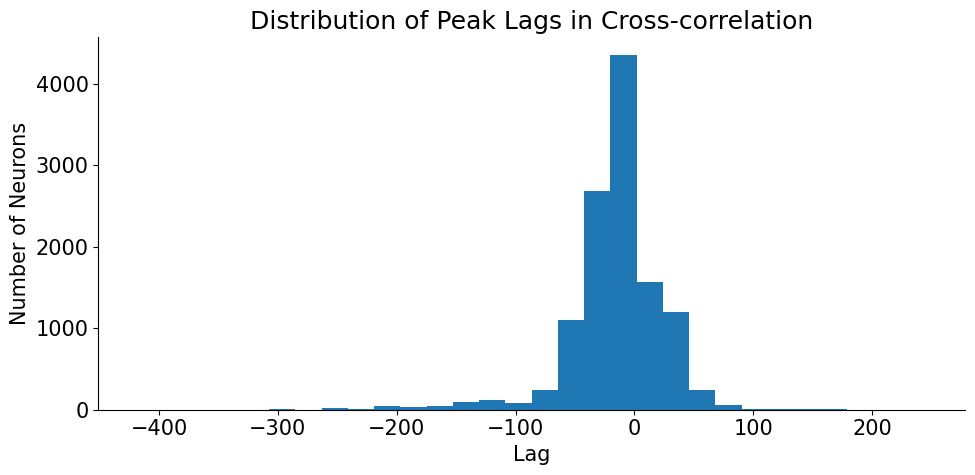

In [15]:
# Find the lag with the maximum correlation for each neuron
peak_lags = [lags[np.argmax(correlation)] for correlation in all_correlations]

# Plot the distribution of peak lags
plt.figure(figsize=(10, 5))
plt.hist(peak_lags, bins=30)
plt.xlabel('Lag')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Peak Lags in Cross-correlation')
plt.show()


In [16]:
import pandas as pd

unique, counts = np.unique(peak_lags, return_counts=True)
peaks=np.asarray((unique, counts)).T
threshold = np.mean(counts)
large_peaks = peaks[peaks[:, 1] > threshold]

lag_df = pd.DataFrame(large_peaks, columns=['Lag', 'Count'])
top_counts = lag_df['Count'].nlargest(10)

# Get the lags corresponding to these top counts
top_lags = lag_df[lag_df['Count'].isin(top_counts)]
top_lags=top_lags.sort_values(by='Count', ascending=False)
# Display the results
print("Top 10 Lag Counts:")
print(top_lags)


Top 10 Lag Counts:
    Lag  Count
56   -1   1146
55   -2    876
57    0    630
54   -3    327
58    1    247
28  -30    207
27  -31    188
26  -32    172
29  -29    162
53   -4    146


Preparing the data to add in the lag. We are going to take the top 3 lag timebins, i.e. -1,-2 and 0

In [33]:
X = dat['sresp'].T  # Shape (timebins, neurons)
y = dat['pupilArea'].flatten()

X_lagged = np.hstack([X[:-2], X[1:-1], X[2:]])  # Combining -2, -1, 0 lags
y_lagged = y[2:]

y_test_old=y_test

X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, random_state=42)
alphas = np.logspace(-6, 6, 13)

In [18]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

y_pred = lasso_cv.predict(X_test)
y_lasso_lagged=y_pred

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Lasso Regression with Lagged Features:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {lasso_cv.alpha_}')

Lasso Regression with Lagged Features:
Mean Squared Error: 12845.16
R^2 Score: 0.91
Best Alpha: 100.0


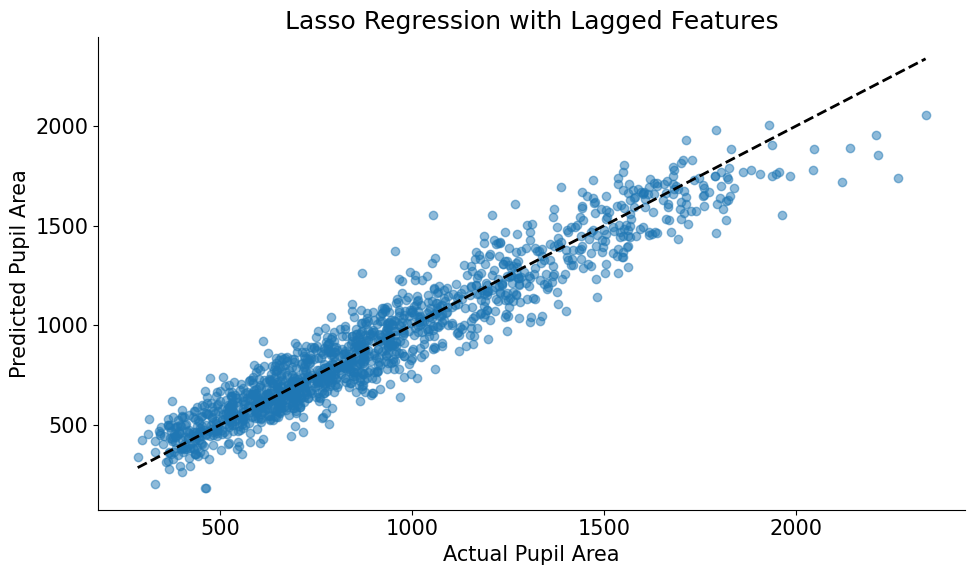

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression with Lagged Features')
plt.show()


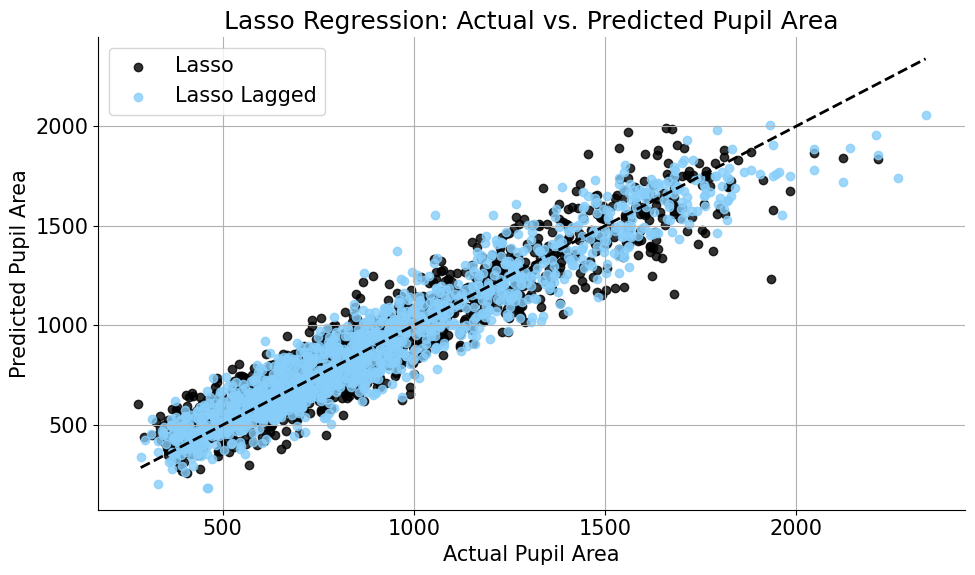

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_old, y_lasso, color='black', alpha=0.8, label='Lasso')
plt.scatter(y_test, y_lasso_lagged, color='lightskyblue', alpha=0.8, label='Lasso Lagged')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

y_pred = ridge_cv.predict(X_test)
y_ridge_lagged = y_pred

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Ridge Regression with Lagged Features:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {ridge_cv.alpha_}')

Ridge Regression with Lagged Features:
Mean Squared Error: 13184.66
R^2 Score: 0.91
Best Alpha: 1000000.0


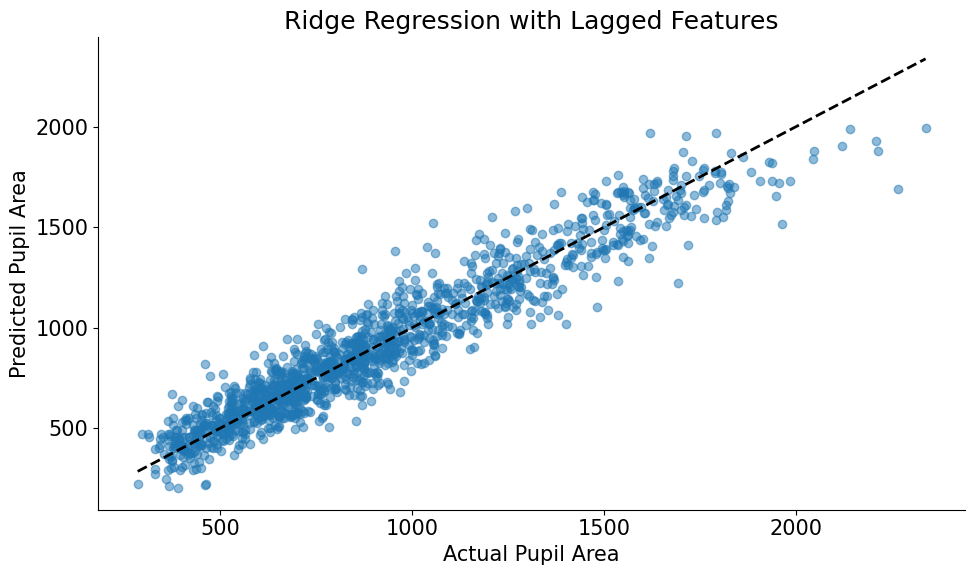

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression with Lagged Features')
plt.show()

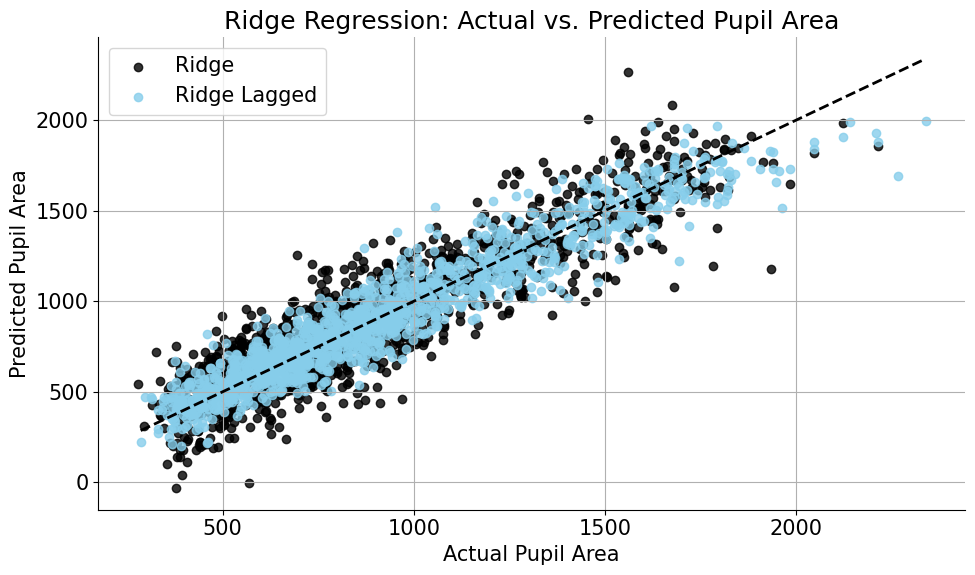

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_old, y_ridge, color='black', alpha=0.8, label='Ridge')
plt.scatter(y_test, y_ridge_lagged, color='skyblue', alpha=0.8, label='Ridge Lagged')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
l1_ratios = np.linspace(0.1, 1.0, 10)
elasticnet_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
elasticnet_cv.fit(X_train, y_train)

y_pred = elasticnet_cv.predict(X_test)
y_elastic_lagged = y_pred

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'ElasticNet Regression with Lagged Features:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {elasticnet_cv.alpha_}')
print(f'Best L1 Ratio: {elasticnet_cv.l1_ratio_}')

ElasticNet Regression with Lagged Features:
Mean Squared Error: 12385.32
R^2 Score: 0.92
Best Alpha: 1000.0
Best L1 Ratio: 0.1


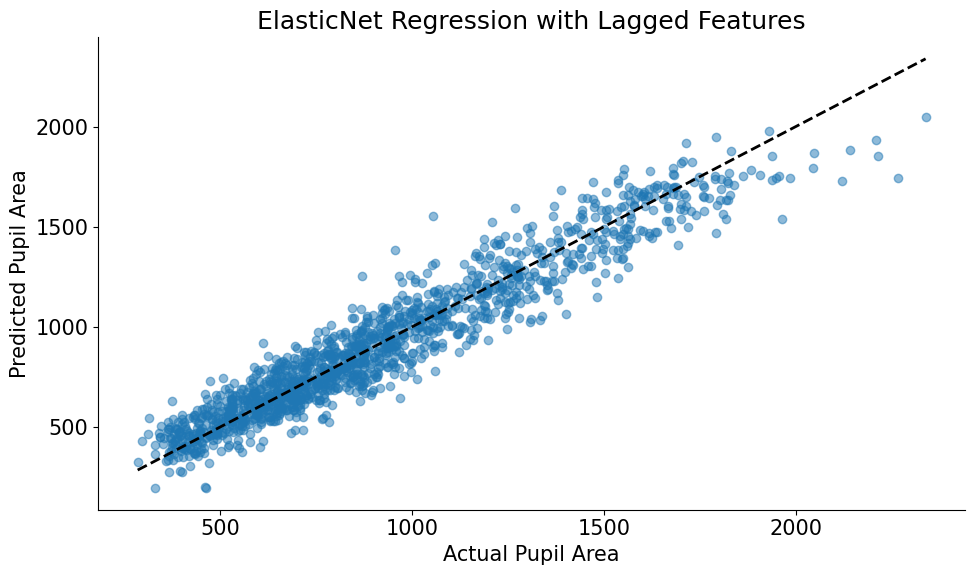

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet Regression with Lagged Features')
plt.show()

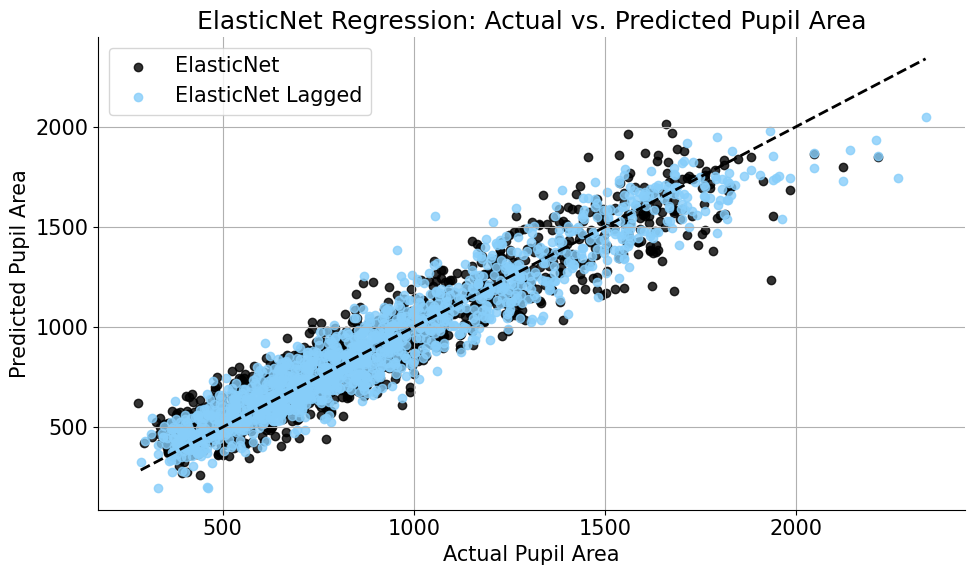

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_old, y_elastic, color='black', alpha=0.8, label='ElasticNet')
plt.scatter(y_test, y_elastic_lagged, color='lightskyblue', alpha=0.8, label='ElasticNet Lagged')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet Regression: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

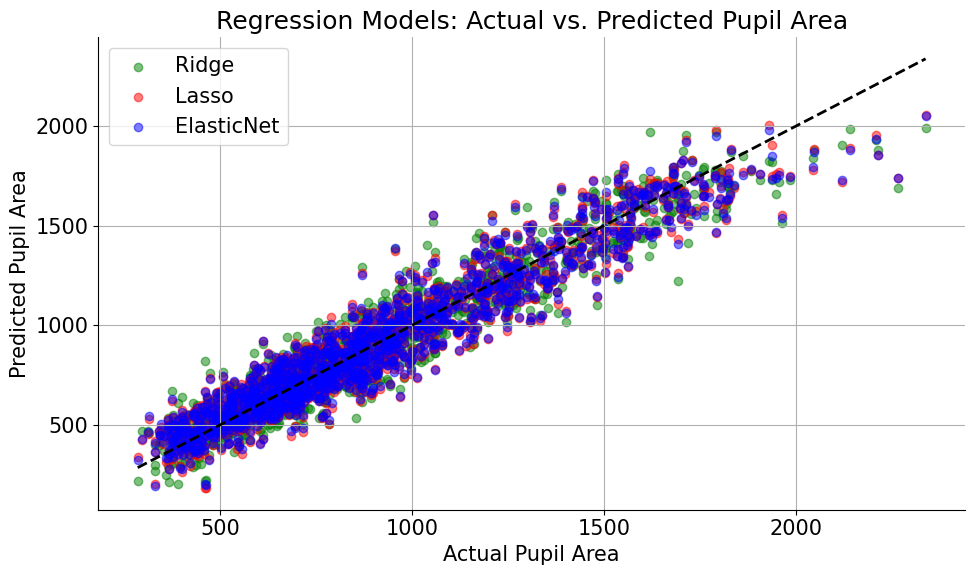

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_ridge_lagged, color='green', alpha=0.5, label='Ridge')
plt.scatter(y_test, y_lasso_lagged, color='red', alpha=0.5, label='Lasso')
plt.scatter(y_test, y_elastic_lagged, color='blue', alpha=0.5, label='ElasticNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Regression Models: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
n_lags = 3 
neural_responses = X_test[:, :-n_lags].mean(axis=1)  # Summing across neurons for each timebin
high_response_threshold = np.percentile(neural_responses, 75)
low_response_threshold = np.percentile(neural_responses, 25)

# Determine which responses are high, low, or medium
high_response_indices = neural_responses >= high_response_threshold
low_response_indices = neural_responses <= low_response_threshold
medium_response_indices = (neural_responses > low_response_threshold) & (neural_responses < high_response_threshold)

high_response_indices, low_response_indices,medium_response_indices, high_response_threshold, low_response_threshold


(array([False,  True, False, ..., False, False, False]),
 array([False, False, False, ...,  True,  True, False]),
 array([ True, False,  True, ..., False, False,  True]),
 42.00255107879639,
 37.147287368774414)

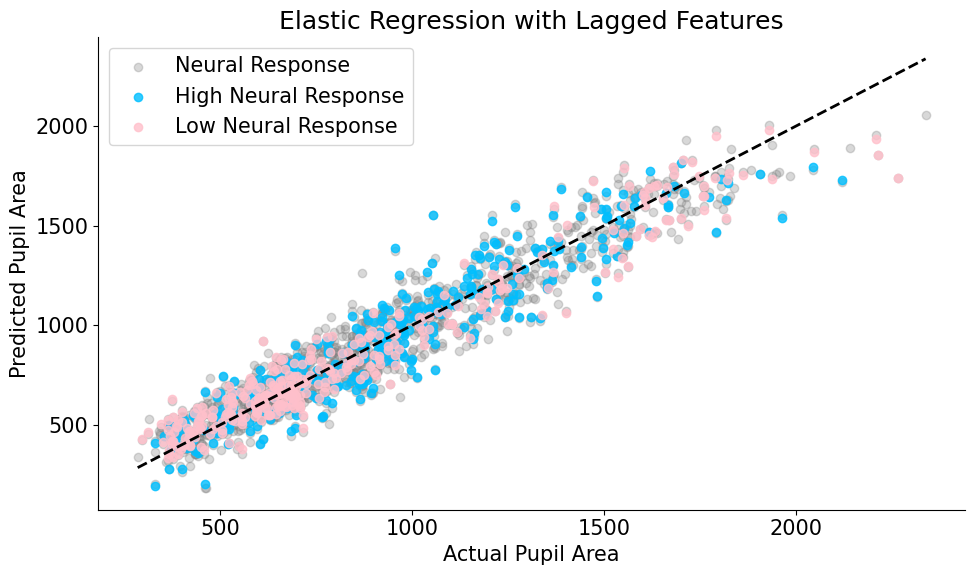

In [89]:

# Plotting with color coding
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_lasso_lagged, color='gray', alpha=0.3, label='Neural Response')
plt.scatter(y_test[high_response_indices], y_elastic_lagged[high_response_indices], color='deepskyblue', alpha=0.8, label='High Neural Response')
plt.scatter(y_test[low_response_indices], y_elastic_lagged[low_response_indices], color='pink', alpha=0.8, label='Low Neural Response')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Elastic Regression with Lagged Features')
plt.legend()
plt.show()

Insights: Even though both high and low firing are scattered across the dataset, high firing ones are clustered a little closer to the prediction line indicating that our model is able to predict pupil area better when neurons are more active

# Other Stuff which didn't give any insights

## Network Analysis

In [90]:
import numpy as np
import networkx as nx
from sklearn.metrics import pairwise_distances

# Assuming `dat['sresp']` contains neural response data
neural_responses = dat['sresp']
correlation_matrix = np.corrcoef(neural_responses)

# Create a graph from the correlation matrix
threshold = 0.5  # Set a threshold for edges
edges = np.where(correlation_matrix > threshold)
G = nx.Graph()
for i, j in zip(*edges):
    if i != j:  # Avoid self-loops
        G.add_edge(i, j, weight=correlation_matrix[i, j])


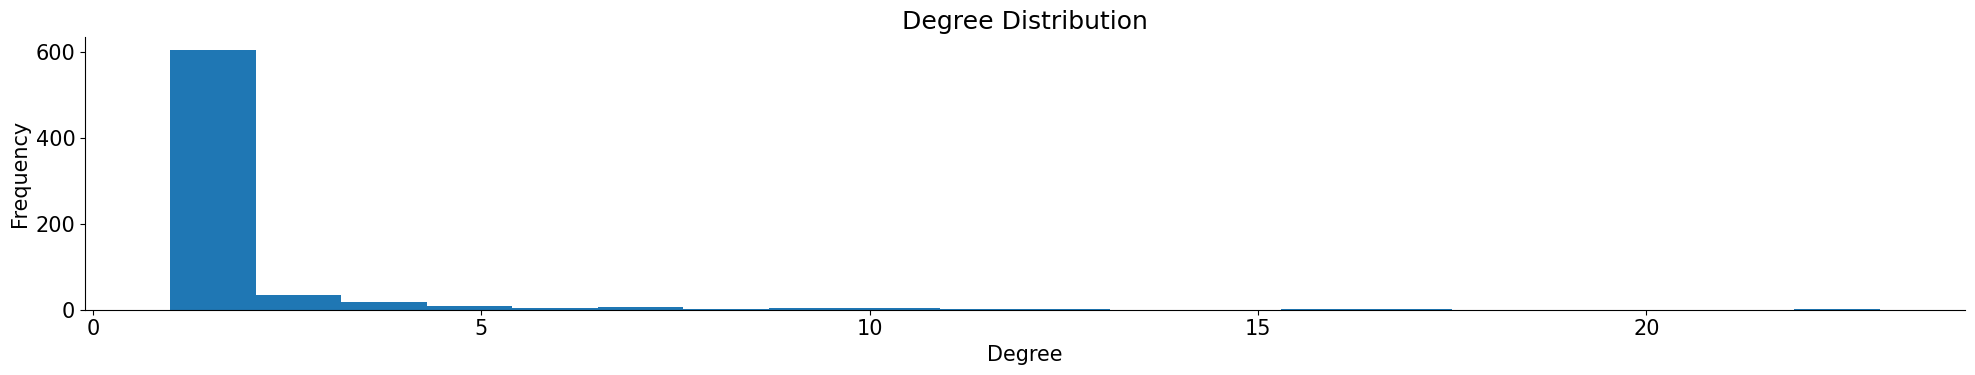

In [93]:
import matplotlib.pyplot as plt
import networkx as nx

# Degree distribution
degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence, bins=20)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()


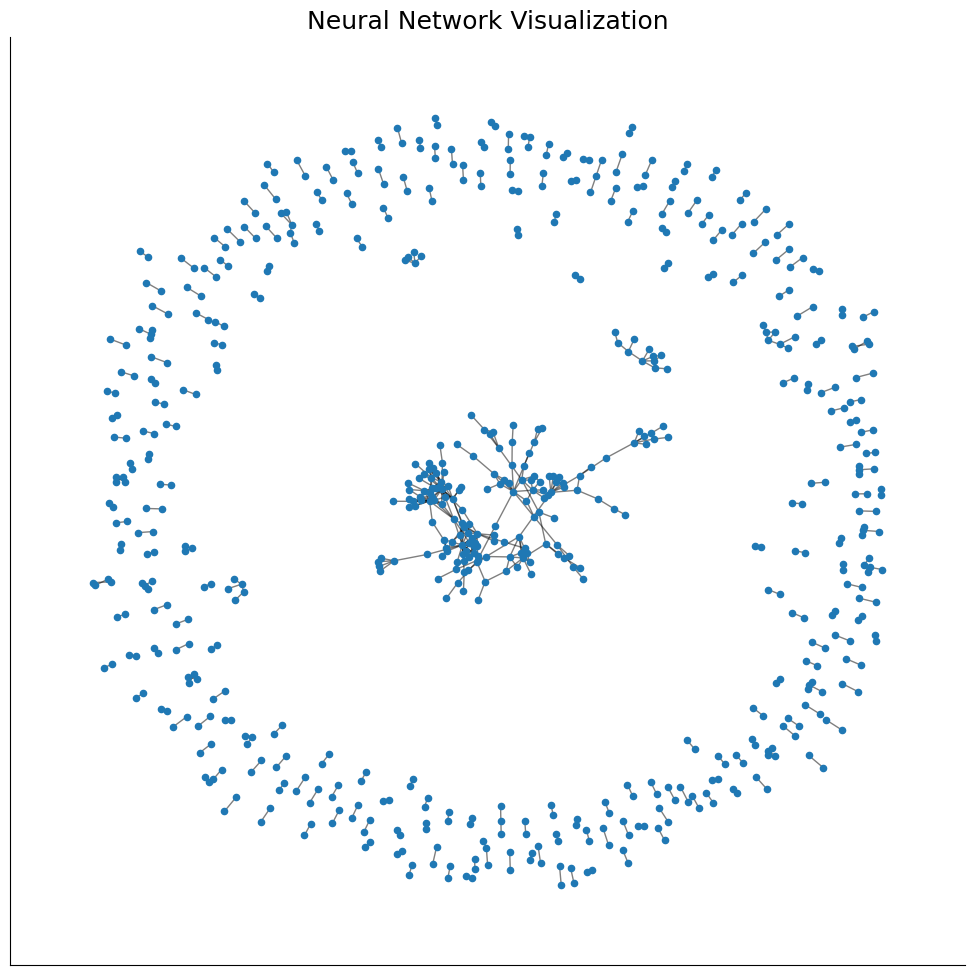

In [94]:
# Network visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Neural Network Visualization')
plt.show()


In [95]:
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
top_10_nodes = [node for node, _ in sorted_degree[:10]]
print("Top 10 nodes by degree centrality:", top_10_nodes)


Top 10 nodes by degree centrality: [6292, 2404, 2801, 6449, 3873, 135, 329, 474, 6472, 3622]


In [96]:
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
top_10_betweenness = [node for node, _ in sorted_betweenness[:10]]
print("Top 10 nodes by betweenness centrality:", top_10_betweenness)


Top 10 nodes by betweenness centrality: [1399, 6364, 10334, 7863, 5282, 280, 135, 6292, 3748, 1236]


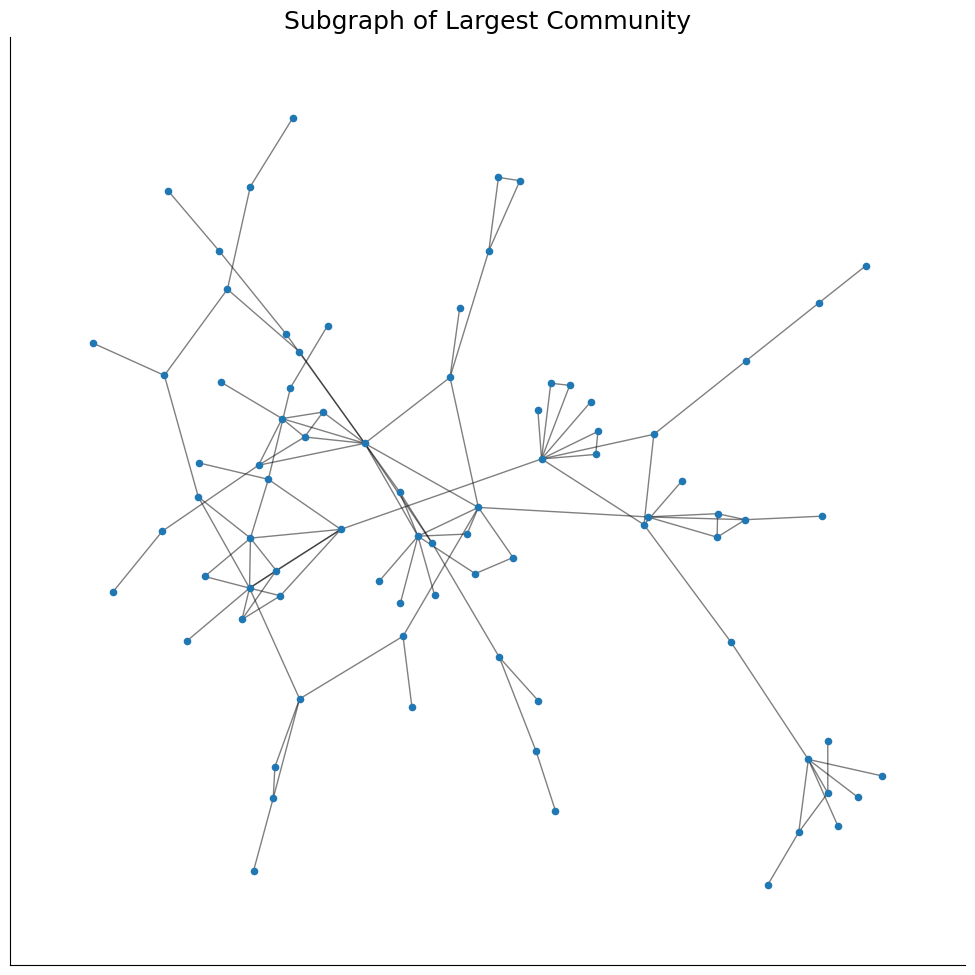

Number of nodes in largest community: 82


In [112]:
import networkx as nx
import matplotlib.pyplot as plt

# Perform Girvan-Newman community detection
def girvan_newman(G):
    # Copy the graph to avoid modifying the original
    G = G.copy()
    components = list(nx.connected_components(G))
    while len(components) == 1:
        # Find the edge with the highest betweenness centrality
        edge = max(nx.betweenness_centrality(G, normalized=False).items(), key=lambda x: x[1])[0]
        G.remove_edge(*edge)
        components = list(nx.connected_components(G))
    return components

# Get communities
communities = girvan_newman(G)

# Draw the largest community
largest_community = max(communities, key=len)
subgraph = G.subgraph(largest_community)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph)  # Positions for all nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=20)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
plt.title('Subgraph of Largest Community')
plt.show()

print(f'Number of nodes in largest community: {len(largest_community)}')


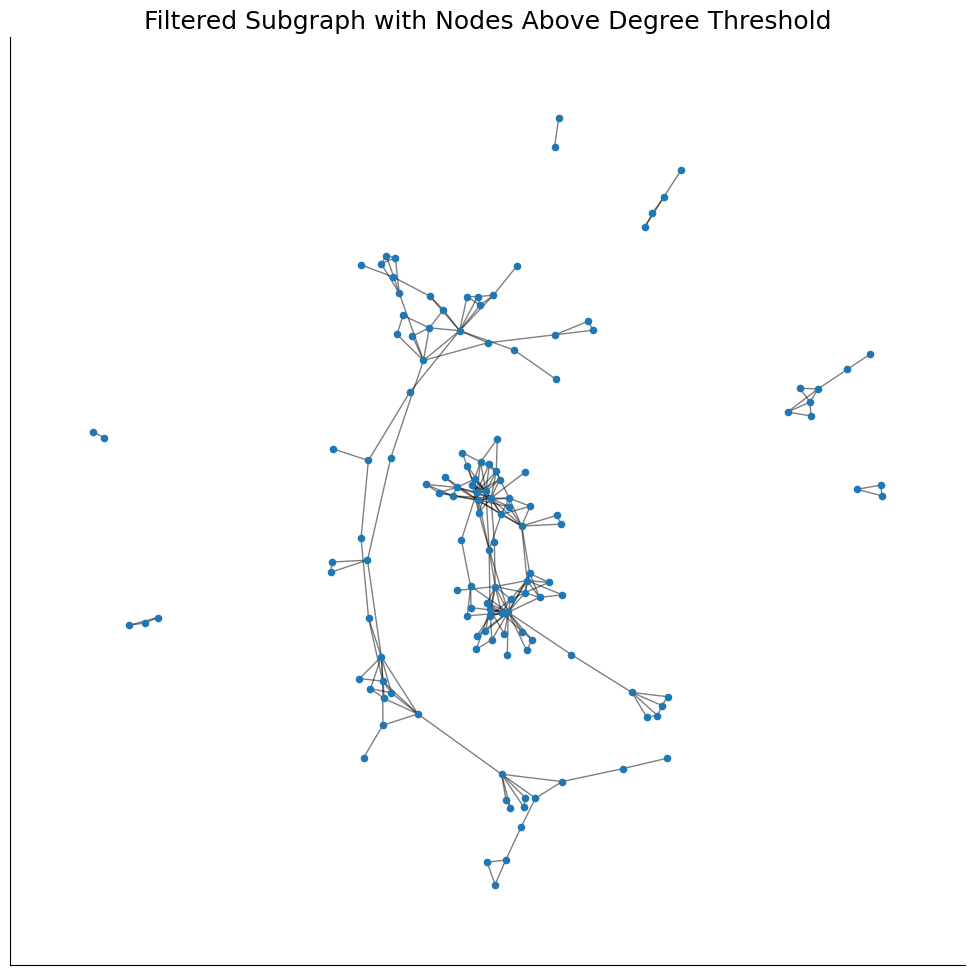

Number of nodes in filtered subgraph: 139


In [121]:
import networkx as nx
import matplotlib.pyplot as plt

#Mean is 1.6445086705202312
degree_threshold = np.mean([degree for node, degree in G.degree()])  # or set your own threshold
# Filter nodes based on degree
high_degree_nodes = [node for node, degree in G.degree() if degree > degree_threshold]

# Create subgraph with nodes having degree above threshold
subgraph = G.subgraph(high_degree_nodes)

# Remove isolated nodes from the subgraph
subgraph = nx.Graph(subgraph)  # Recreate the graph to remove isolated nodes
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))

# Visualize the filtered subgraph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph)  # Positions for all nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=20)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
plt.title('Filtered Subgraph with Nodes Above Degree Threshold')
plt.show()

print(f'Number of nodes in filtered subgraph: {len(subgraph.nodes())}')


In [125]:
# Convert high-degree nodes to a list of indices
high_degree_nodes = np.array(high_degree_nodes)

high_degree_sresp = dat['sresp'][high_degree_nodes, :]  # Shape (number of high-degree nodes, timebins)
high_degree_sresp = high_degree_sresp.T  # Transpose to shape (timebins, number of high-degree nodes)

X_high_degree_lagged = np.hstack([high_degree_sresp[:-2], high_degree_sresp[1:-1], high_degree_sresp[2:]])
y_high_degree_lagged = y[2:]

X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high_degree_lagged, y_high_degree_lagged, test_size=0.2, random_state=42)


In [126]:
# RidgeCV Model
ridge_cv_high = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv_high.fit(X_train_high, y_train_high)

y_pred_high = ridge_cv_high.predict(X_test_high)
y_ridge_high = y_pred_high
mse_high = mean_squared_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

print(f'Ridge Regression with High-Degree Nodes:')
print(f'Mean Squared Error: {mse_high:.2f}')
print(f'R^2 Score: {r2_high:.2f}')
print(f'Best Alpha: {ridge_cv_high.alpha_}')


Ridge Regression with High-Degree Nodes:
Mean Squared Error: 26459.62
R^2 Score: 0.82
Best Alpha: 1000000.0


In [127]:

# LassoCV Model
lasso_cv_high = LassoCV(alphas=alphas, cv=5)
lasso_cv_high.fit(X_train_high, y_train_high)

y_pred_high = lasso_cv_high.predict(X_test_high)
y_lasso_high = y_pred_high
mse_high = mean_squared_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

print(f'Lasso Regression with High-Degree Nodes:')
print(f'Mean Squared Error: {mse_high:.2f}')
print(f'R^2 Score: {r2_high:.2f}')
print(f'Best Alpha: {lasso_cv_high.alpha_}')


Lasso Regression with High-Degree Nodes:
Mean Squared Error: 26426.34
R^2 Score: 0.82
Best Alpha: 10.0


In [128]:
elasticnet_cv_high = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
elasticnet_cv_high.fit(X_train_high, y_train_high)

y_pred_high = elasticnet_cv_high.predict(X_test_high)
mse_high = mean_squared_error(y_test_high, y_pred_high)
r2_high = r2_score(y_test_high, y_pred_high)

print(f'ElasticNet Regression with High-Degree Nodes:')
print(f'Mean Squared Error: {mse_high:.2f}')
print(f'R^2 Score: {r2_high:.2f}')
print(f'Best Alpha: {elasticnet_cv_high.alpha_}')
print(f'Best L1 Ratio: {elasticnet_cv_high.l1_ratio_}')

ElasticNet Regression with High-Degree Nodes:
Mean Squared Error: 26060.01
R^2 Score: 0.82
Best Alpha: 100.0
Best L1 Ratio: 0.4


In [130]:
# Convert list of nodes to NumPy array
largest_subgraph_nodes = np.array(list(subgraph.nodes))

# Extract neural responses for the largest connected subgraph
largest_subgraph_sresp = dat['sresp'][largest_subgraph_nodes, :]  # Shape (number of subgraph nodes, timebins)
largest_subgraph_sresp = largest_subgraph_sresp.T  # Transpose to shape (timebins, number of subgraph nodes)

# Prepare lagged features
X_subgraph_lagged = np.hstack([largest_subgraph_sresp[:-2], largest_subgraph_sresp[1:-1], largest_subgraph_sresp[2:]])
y_subgraph_lagged = y[2:]

# Train-test split
X_train_subgraph, X_test_subgraph, y_train_subgraph, y_test_subgraph = train_test_split(X_subgraph_lagged, y_subgraph_lagged, test_size=0.2, random_state=42)


In [131]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

# RidgeCV Model
ridge_cv_subgraph = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv_subgraph.fit(X_train_subgraph, y_train_subgraph)

y_pred_subgraph = ridge_cv_subgraph.predict(X_test_subgraph)
mse_subgraph = mean_squared_error(y_test_subgraph, y_pred_subgraph)
r2_subgraph = r2_score(y_test_subgraph, y_pred_subgraph)

print(f'Ridge Regression with Largest Connected Subgraph:')
print(f'Mean Squared Error: {mse_subgraph:.2f}')
print(f'R^2 Score: {r2_subgraph:.2f}')
print(f'Best Alpha: {ridge_cv_subgraph.alpha_}')


Ridge Regression with Largest Connected Subgraph:
Mean Squared Error: 26638.75
R^2 Score: 0.82
Best Alpha: 1000000.0


In [132]:
from sklearn.linear_model import LassoCV

# LassoCV Model
lasso_cv_subgraph = LassoCV(alphas=alphas, cv=5)
lasso_cv_subgraph.fit(X_train_subgraph, y_train_subgraph)

y_pred_lasso_subgraph = lasso_cv_subgraph.predict(X_test_subgraph)
mse_subgraph = mean_squared_error(y_test_subgraph, y_pred_subgraph)
r2_subgraph = r2_score(y_test_subgraph, y_pred_subgraph)

print(f'Lasso Regression with Largest Connected Subgraph:')
print(f'Mean Squared Error: {mse_subgraph:.2f}')
print(f'R^2 Score: {r2_subgraph:.2f}')
print(f'Best Alpha: {lasso_cv_subgraph.alpha_}')


Lasso Regression with Largest Connected Subgraph:
Mean Squared Error: 26638.75
R^2 Score: 0.82
Best Alpha: 10.0


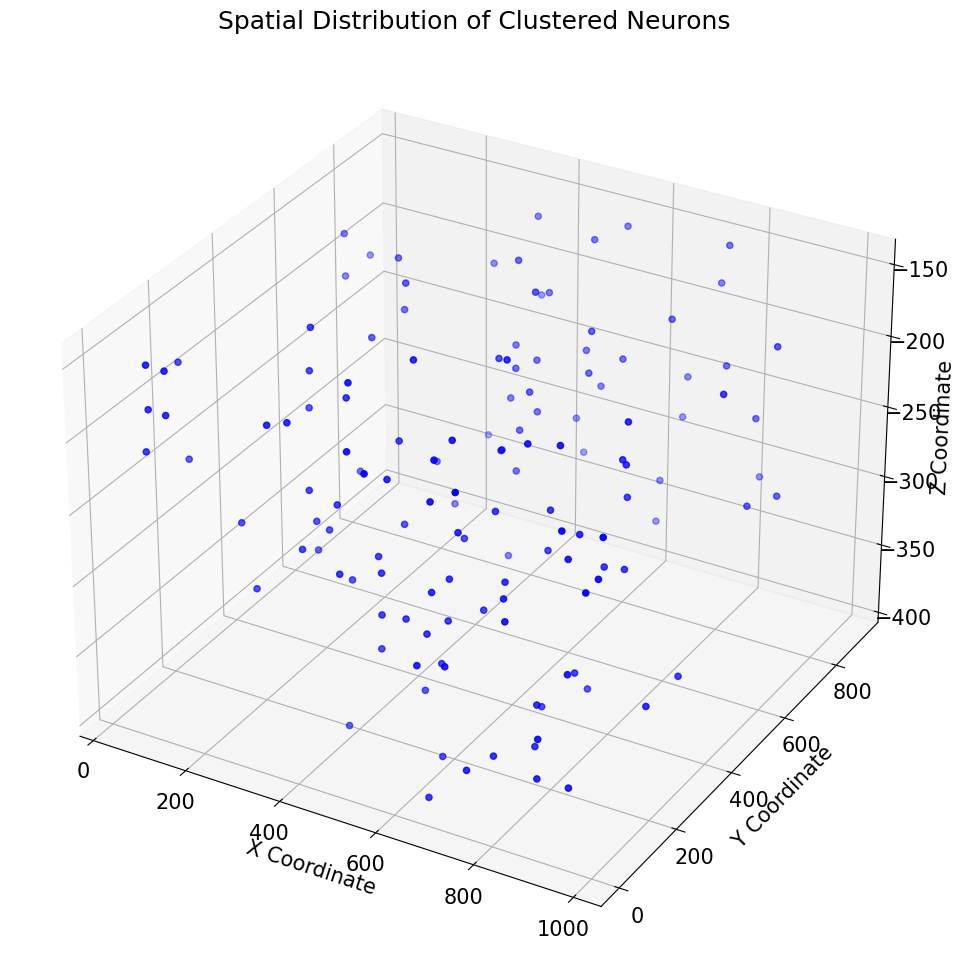

In [135]:
import pandas as pd

# Extract spatial locations of clustered neurons
spatial_locations = dat['xyz'][:, list(subgraph.nodes)]

# Convert to DataFrame for easier plotting
df_spatial = pd.DataFrame(spatial_locations.T, columns=['X', 'Y', 'Z'])

# Plot spatial distribution
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_spatial['X'], df_spatial['Y'], df_spatial['Z'], c='b', marker='o')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Spatial Distribution of Clustered Neurons')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Create edge index and edge attributes for PyTorch Geometric
edge_index = torch.tensor([edges], dtype=torch.long)
edge_attr = torch.tensor([correlation_matrix[edges]], dtype=torch.float)

# Create node features (use neural responses as an example)
x = torch.tensor(neural_responses.T, dtype=torch.float)

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model, define loss and optimizer
model = GCN(in_channels=neural_responses.shape[0], out_channels=2)  # Example output dimension
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, labels)  # Assuming `labels` is a tensor of ground truth labels
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    # Further evaluation and analysis here


## Spatial stuff

In [5]:
z_coordinates = dat['xyz'][:, 2]
layer_boundaries = np.linspace(z_coordinates.min(), z_coordinates.max(), 7)


Added Spatial features also to predictions. Did not improve accuracy at all

Shape of X: (7018, 11983)
Shape of xyz_expanded: (84096694, 3)
Ridge Regression with spatial features:
Mean Squared Error: 27127.85
R^2 Score: 0.80
Best Alpha: 1000000.0


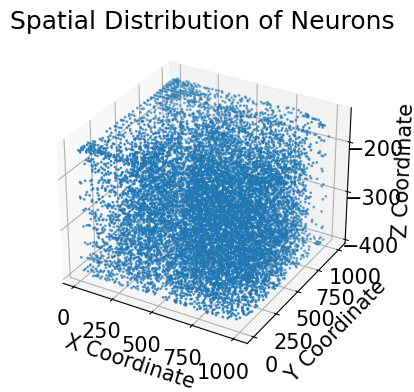

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load data
X = dat['sresp'].T  # Neural response data (timebins x neurons)
y = dat['pupilArea'].flatten()
xyz = dat['xyz'].T  # Spatial coordinates (neurons x 3)

# Normalize spatial data
xyz_normalized = (xyz - np.mean(xyz, axis=0)) / np.std(xyz, axis=0)

# Expand spatial data to match the number of timebins
# Repeat spatial data for each timebin
xyz_expanded = np.tile(xyz_normalized, (X.shape[0], 1))

# Check dimensions
print("Shape of X:", X.shape)  # (7018, 11983)
print("Shape of xyz_expanded:", xyz_expanded.shape)  # Should be (7018, 11983 * 3)

# Combine spatial data with neural response
# xyz_expanded should be reshaped to match the number of timebins and neurons
xyz_expanded = xyz_expanded.reshape(X.shape[0], xyz_normalized.shape[0] * xyz_normalized.shape[1])

# Combine with neural response data
X_combined = np.hstack((X, xyz_expanded))

# Split the data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_combined, y, np.arange(X_combined.shape[0]), test_size=0.2, random_state=42)

# Define alpha range for RidgeCV
alphas = np.logspace(-6, 6, 13)

# Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_cv.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Ridge Regression with spatial features:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {ridge_cv.alpha_}')

# Visualization: Spatial distribution of neurons
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=1)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Spatial Distribution of Neurons')
plt.show()


C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.612e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.764e+05, toleranc

Ridge Regression with spatial features:
Mean Squared Error: 15332.56
R^2 Score: 0.89
Best Alpha: 1000000.0


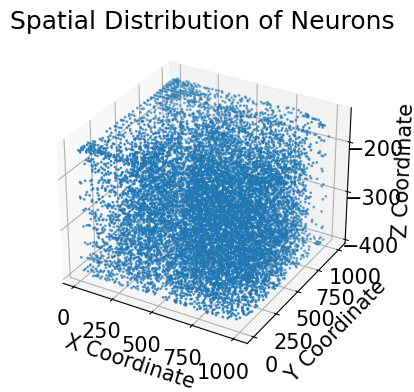

In [8]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_cv.predict(X_test)
y_lasso = y_pred

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Ridge Regression with spatial features:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {ridge_cv.alpha_}')

# Visualization: Spatial distribution of neurons
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=1)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Spatial Distribution of Neurons')
plt.show()




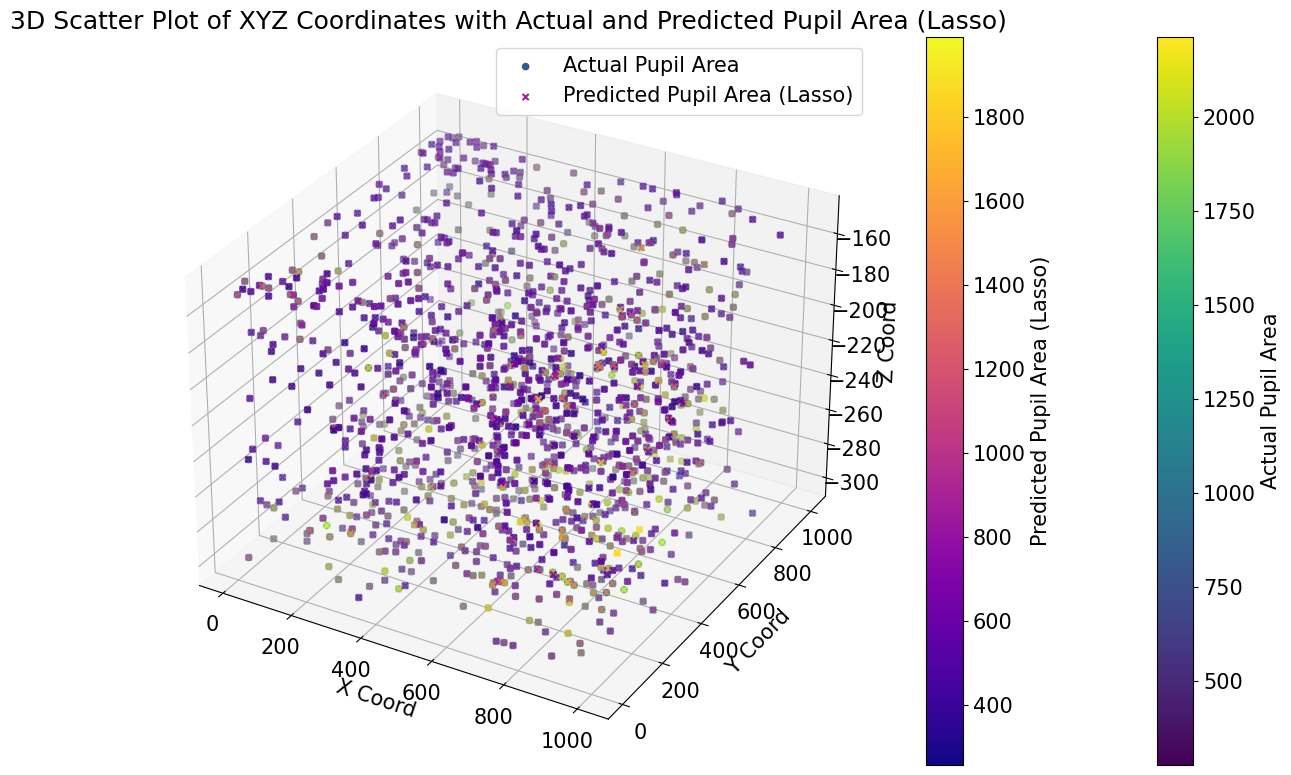

In [84]:
xyz_coords = dat['xyz'].T
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xyz_coords[test_indices, 0], xyz_coords[test_indices, 1], xyz_coords[test_indices, 2], c=y_test, cmap='viridis', label='Actual Pupil Area')
scatter_pred = ax.scatter(xyz_coords[test_indices, 0], xyz_coords[test_indices, 1], xyz_coords[test_indices, 2], c=y_lasso, cmap='plasma', marker='x', label='Predicted Pupil Area (Lasso)')
ax.set_xlabel('X Coord')
ax.set_ylabel('Y Coord')
ax.set_zlabel('Z Coord')
ax.set_title('3D Scatter Plot of XYZ Coordinates with Actual and Predicted Pupil Area (Lasso)')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Actual Pupil Area')
plt.colorbar(scatter_pred, ax=ax, label='Predicted Pupil Area (Lasso)')
plt.show()

In [89]:
import plotly.graph_objects as go
fig = go.Figure()

# Actual Pupil Area
fig.add_trace(go.Scatter3d(
    x=xyz_coords[test_indices, 0], y=xyz_coords[test_indices, 1], z=xyz_coords[test_indices, 2],
    mode='markers',
    marker=dict(size=5, color=y_test, colorscale='Viridis', opacity=0.6),
    name='Actual Pupil Area'
))

# Predicted Pupil Area (Lasso)
fig.add_trace(go.Scatter3d(
    x=xyz_coords[test_indices, 0], y=xyz_coords[test_indices, 1], z=xyz_coords[test_indices, 2],
    mode='markers',
    marker=dict(size=5, color=y_lasso, colorscale='Plasma', opacity=0.6),
    name='Predicted Pupil Area (Lasso)'
))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X Coord',
        yaxis_title='Y Coord',
        zaxis_title='Z Coord'
    ),
    title='3D Scatter Plot of XYZ Coordinates with Actual and Predicted Pupil Area (Lasso)',
    showlegend=True
)

fig.show()

Layers in spatial data and their performance. Again not much insight

In [58]:
layers

[array([False, False, False, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [26]:
layer_contributions

[35.952576, 33.12756, 34.407402, 32.313644, 33.175552, 36.918518]

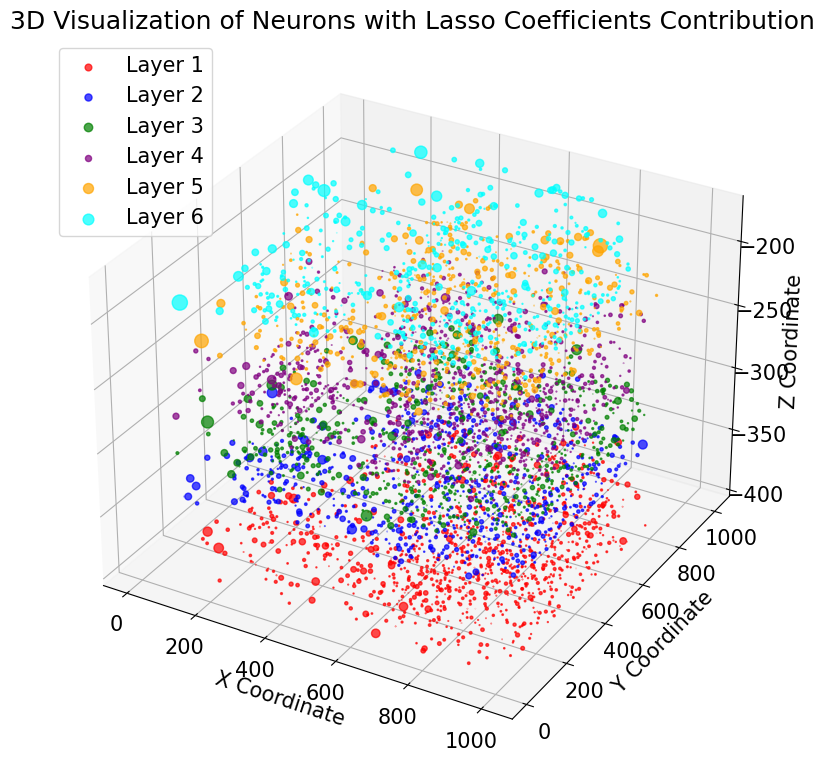

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
for i, mask in enumerate(layers):
    neurons_in_layer = xyz_coordinates[mask]
    coefficients = layer_models[i].coef_

    # Use the absolute value of the coefficients to determine the size of the scatter points
    sizes = np.abs(coefficients) * 100  # Scale up for better visualization

    sc = ax.scatter(neurons_in_layer[:, 0], neurons_in_layer[:, 1], neurons_in_layer[:, 2], 
                    c=colors[i], s=sizes, label=f'Layer {i + 1}', alpha=0.7)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('3D Visualization of Neurons with Lasso Coefficients Contribution')
plt.legend()
plt.show()

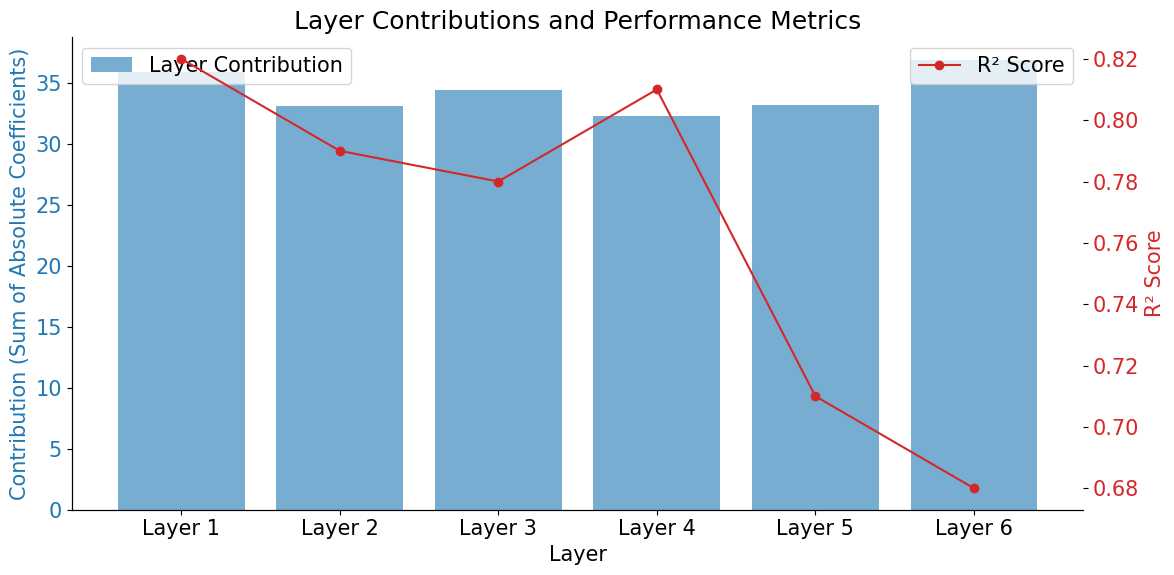

In [27]:
import matplotlib.pyplot as plt

# Layer contributions
layer_contributions = [35.95, 33.13, 34.41, 32.31, 33.18, 36.92]

# Performance metrics
layer_names = [f'Layer {i+1}' for i in range(6)]
mse_scores = [24017.11, 28404.74, 29825.09, 26139.26, 38624.20, 43570.25]
r2_scores = [0.82, 0.79, 0.78, 0.81, 0.71, 0.68]

# Plotting contributions and R² scores
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot layer contributions
color = 'tab:blue'
ax1.set_xlabel('Layer')
ax1.set_ylabel('Contribution (Sum of Absolute Coefficients)', color=color)
ax1.bar(layer_names, layer_contributions, color=color, alpha=0.6, label='Layer Contribution')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for R² scores
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('R² Score', color=color)
ax2.plot(layer_names, r2_scores, color=color, marker='o', label='R² Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Layer Contributions and Performance Metrics')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


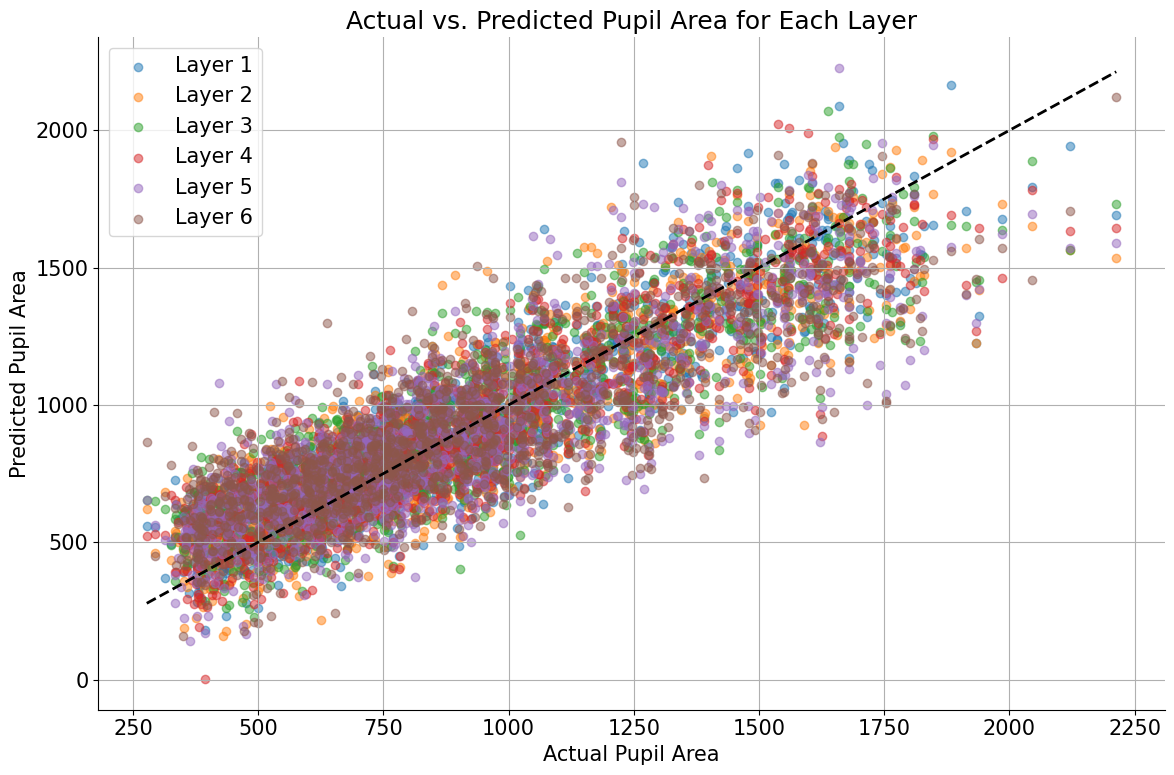

In [31]:
plt.figure(figsize=(12, 8))

# Plot predictions for each layer
for i, y_pred_layer in enumerate(predictions):
    plt.scatter(y_test, y_pred_layer, alpha=0.5, label=layer_labels[i])

# Plotting 1:1 line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Actual vs. Predicted Pupil Area for Each Layer')
plt.legend()
plt.grid(True)
plt.show()

Z-coordinate range: (-390.0, -150.0)
Layer 1 mask: [False False False ...  True  True  True] (shape: (11983,))
Layer 2/3 mask: [False False False ... False False False] (shape: (11983,))
Layer 4 mask: [False False False ... False False False] (shape: (11983,))
Layer 5 mask: [False False False ... False False False] (shape: (11983,))
Layer 6 mask: [False False False ... False False False] (shape: (11983,))
Processing Layer 1 with mask of shape (11983,)
Number of neurons in Layer 1: 2826
X_layer_train shape: (5614, 2826)
X_layer_test shape: (1404, 2826)
Lasso Regression for Layer 1:
Mean Squared Error: 24017.11
R^2 Score: 0.82
Best Alpha: 100.0
Processing Layer 2/3 with mask of shape (11983,)
Number of neurons in Layer 2/3: 2889
X_layer_train shape: (5614, 2889)
X_layer_test shape: (1404, 2889)
Lasso Regression for Layer 2/3:
Mean Squared Error: 22054.48
R^2 Score: 0.84
Best Alpha: 100.0
Processing Layer 4 with mask of shape (11983,)
Number of neurons in Layer 4: 1415
X_layer_train shape

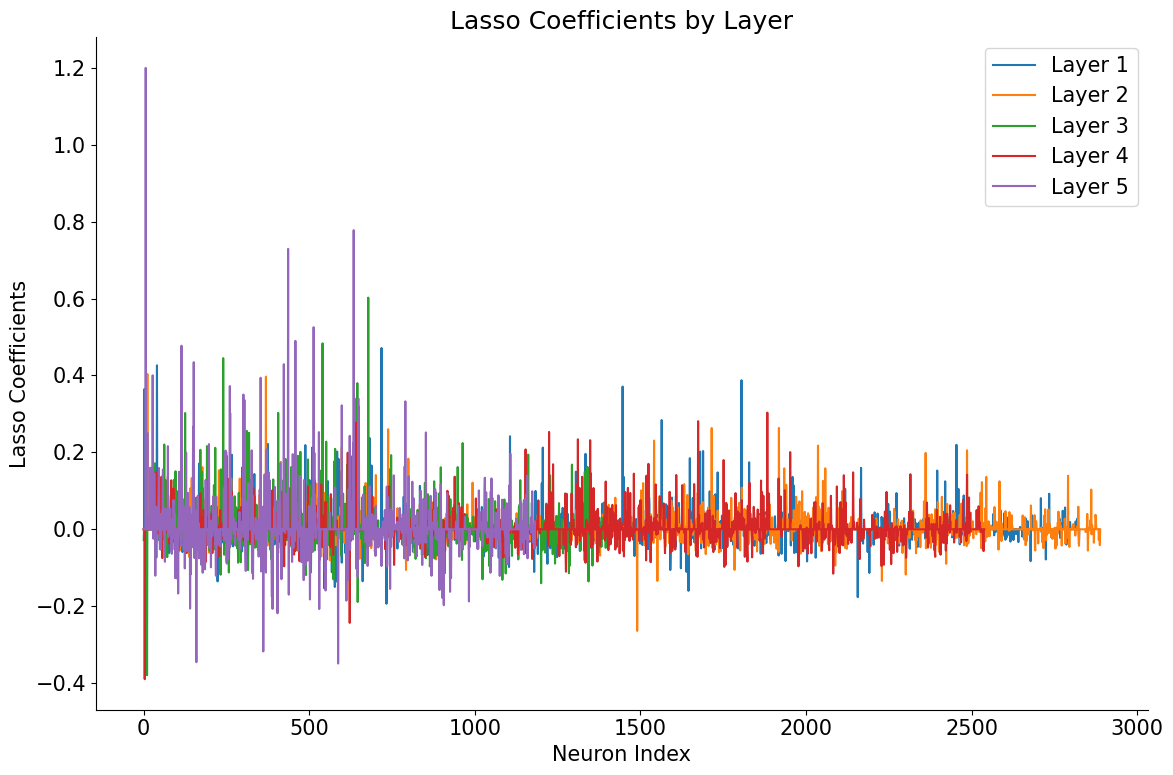

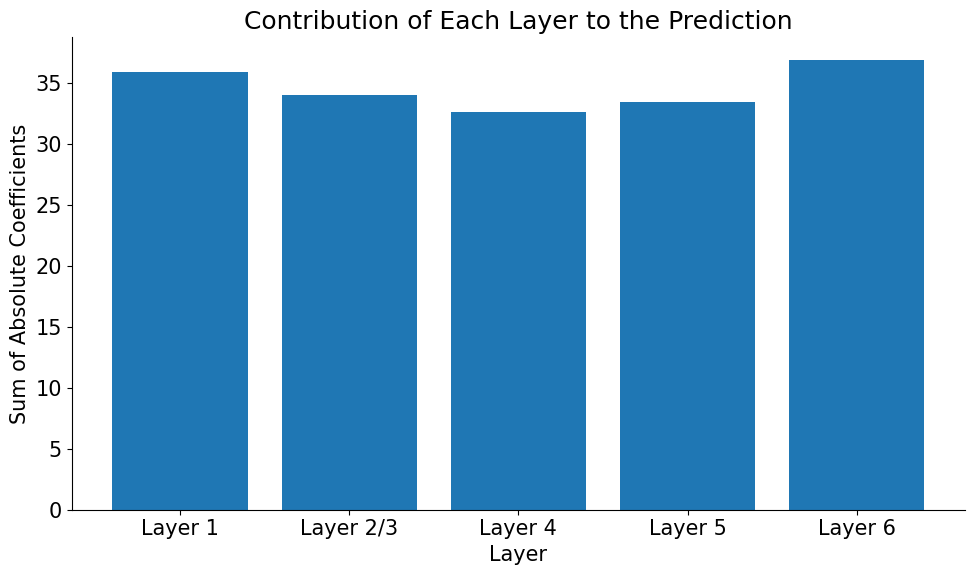

In [88]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Transpose xyz to get neurons by dimensions
xyz_coordinates = dat['xyz'].T  # Shape will be (neurons, 3)
z_coordinates = xyz_coordinates[:, 2]

# Check the range of z-coordinates
z_min, z_max = z_coordinates.min(), z_coordinates.max()
print(f"Z-coordinate range: ({z_min}, {z_max})")

# Define layer ranges adjusted for negative coordinates
layer_ranges = {
    'Layer 1': (z_min, z_min + (z_max - z_min) * 0.2),
    'Layer 2/3': (z_min + (z_max - z_min) * 0.2, z_min + (z_max - z_min) * 0.4),
    'Layer 4': (z_min + (z_max - z_min) * 0.4, z_min + (z_max - z_min) * 0.6),
    'Layer 5': (z_min + (z_max - z_min) * 0.6, z_min + (z_max - z_min) * 0.8),
    'Layer 6': (z_min + (z_max - z_min) * 0.8, z_max)
}

# Create masks for each layer
layers = {}
for layer, (z_min_layer, z_max_layer) in layer_ranges.items():
    mask = (z_coordinates >= z_min_layer) & (z_coordinates < z_max_layer)
    layers[layer] = mask
    print(f'{layer} mask: {mask} (shape: {mask.shape})')

# Prepare the data for regression
X = dat['sresp'].T  # Transpose to get shape (timebins, neurons)
y = dat['pupilArea'].flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define alpha range for LassoCV
alphas = np.logspace(-6, 6, 13)

# Train Lasso regression models for each layer
layer_models = []
predictions = []
layer_labels = []
for layer, mask in layers.items():
    # Check the mask
    print(f'Processing {layer} with mask of shape {mask.shape}')
    
    # Extract neurons corresponding to the current layer
    num_neurons = np.sum(mask)
    print(f'Number of neurons in {layer}: {num_neurons}')
    
    if num_neurons == 0:
        print(f'No neurons in {layer}. Skipping this layer.')
        continue
    
    # Apply mask to the training and testing data
    X_layer_train = X_train[:, mask]
    X_layer_test = X_test[:, mask]
    
    # Check shapes after applying the mask
    print(f'X_layer_train shape: {X_layer_train.shape}')
    print(f'X_layer_test shape: {X_layer_test.shape}')

    lasso_cv = LassoCV(alphas=alphas, cv=5)
    lasso_cv.fit(X_layer_train, y_train)

    y_pred_layer = lasso_cv.predict(X_layer_test)

    mse = mean_squared_error(y_test, y_pred_layer)
    r2 = r2_score(y_test, y_pred_layer)

    print(f'Lasso Regression for {layer}:')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R^2 Score: {r2:.2f}')
    print(f'Best Alpha: {lasso_cv.alpha_}')

    layer_models.append(lasso_cv)
    predictions.append(y_pred_layer)
    layer_labels.append(layer)

# Plot the coefficients for each layer
plt.figure(figsize=(12, 8))
for i, model in enumerate(layer_models):
    plt.plot(model.coef_, label=f'Layer {i + 1}')

plt.xlabel('Neuron Index')
plt.ylabel('Lasso Coefficients')
plt.title('Lasso Coefficients by Layer')
plt.legend()
plt.show()

# Sum of absolute coefficients for each layer
layer_contributions = [np.sum(np.abs(model.coef_)) for model in layer_models]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(layer_contributions) + 1), layer_contributions, tick_label=layer_labels)
plt.xlabel('Layer')
plt.ylabel('Sum of Absolute Coefficients')
plt.title('Contribution of Each Layer to the Prediction')
plt.show()


In [89]:
layer_contributions

[35.952576, 34.053734, 32.6639, 33.483444, 36.918518]

## Same models on first 3 PCs

In [40]:
from sklearn.decomposition import PCA

# PCA Transformation
pca = PCA(n_components=3)  # Adjust number of components as needed
X_pca = pca.fit_transform(X)


# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [65]:
# Ridge Regression with cross-validation on PCA-transformed data
ridge_cv_pca = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = ridge_cv_pca.predict(X_test_pca)
y_ridge_pca=y_pred_pca

# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Ridge Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {ridge_cv_pca.alpha_}')


Ridge Regression with PCA:
Mean Squared Error: 59283.73
R^2 Score: 0.56
Best Alpha: 1000000.0


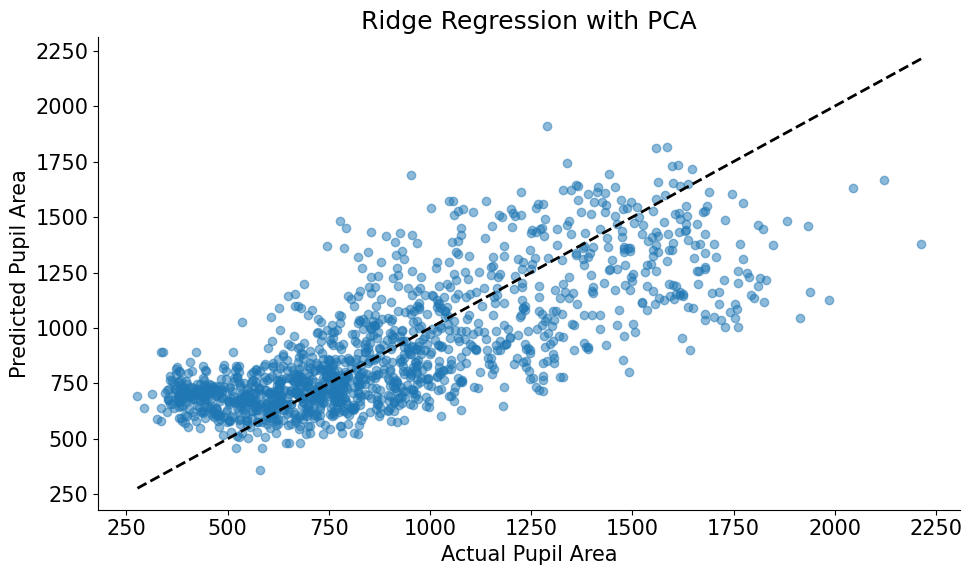

In [66]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression with PCA')
plt.show()

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2154549.75, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12701066.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27464790.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective di

Lasso Regression with PCA:
Mean Squared Error: 59281.66
R^2 Score: 0.56
Best Alpha: 100.0


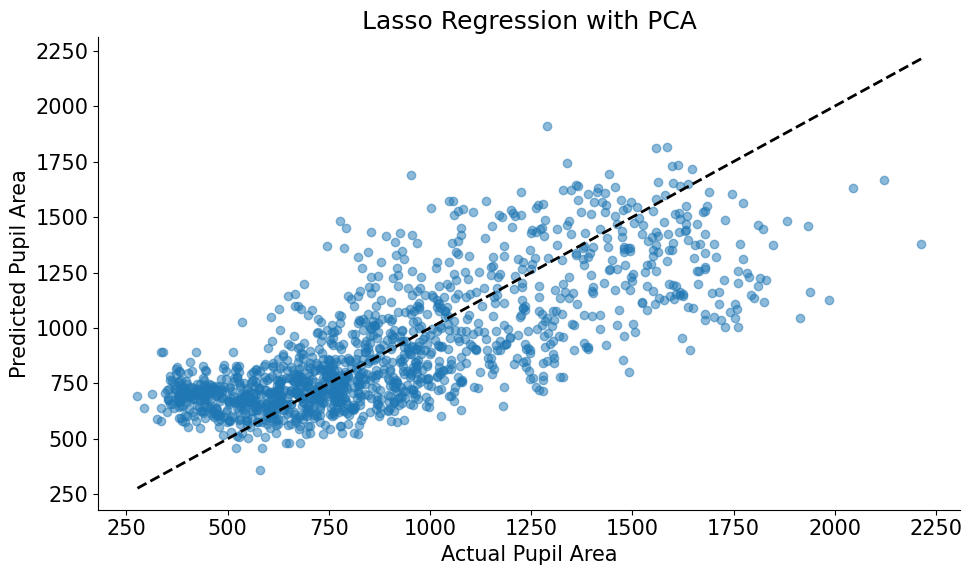

In [68]:
# Lasso Regression with cross-validation on PCA-transformed data
lasso_cv_pca = LassoCV(alphas=alphas, cv=5)
lasso_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = lasso_cv_pca.predict(X_test_pca)
y_lasso_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Lasso Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {lasso_cv_pca.alpha_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression with PCA')
plt.show()


C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29914580.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21549100.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18168502.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective di

ElasticNet with PCA:
Mean Squared Error: 59280.20
R^2 Score: 0.56
Best Alpha: 1000.0, Best L1 ratio: 0.1


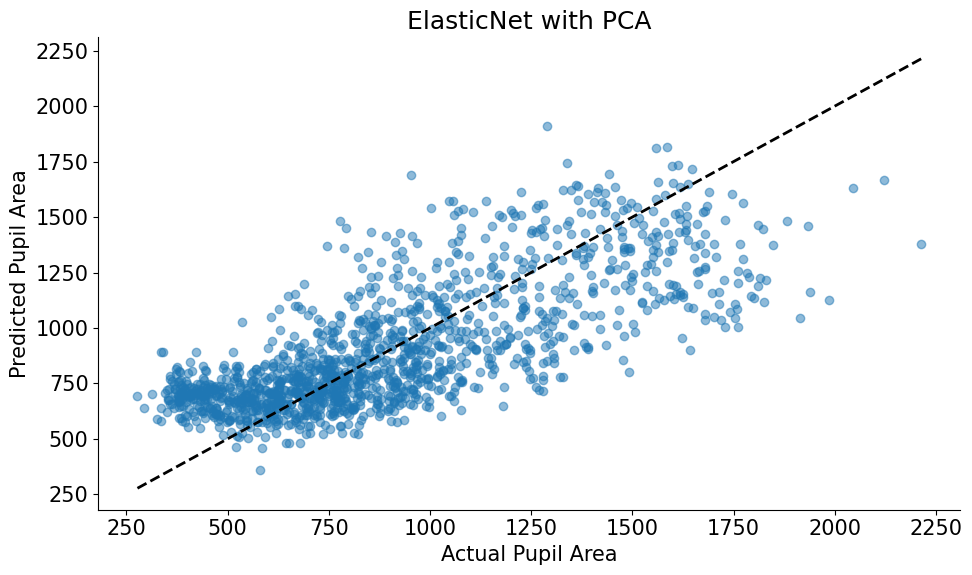

In [70]:
# ElasticNet with cross-validation on PCA-transformed data
elasticnet_cv_pca = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5)
elasticnet_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = elasticnet_cv_pca.predict(X_test_pca)
y_elastic_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'ElasticNet with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {elasticnet_cv_pca.alpha_}, Best L1 ratio: {elasticnet_cv_pca.l1_ratio_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet with PCA')
plt.show()
